In [1]:
import numpy as np
from astropy.io import fits
import numpy as np
import astropy.units as u
import astropy.constants as const

import pprint
import logging
import os

import matplotlib
import matplotlib.pyplot as plt
%pylab inline
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['axes.linewidth'] = 1.
matplotlib.rcParams['lines.linewidth'] = 2.5
matplotlib.rcParams['font.size'] = 15

import scipy.ndimage.interpolation
import scipy.signal
import skimage.transform

cmap='inferno'

Populating the interactive namespace from numpy and matplotlib


## General settings

In [2]:
# scene_pixscale_as = 0.025 # arcsec
# lamoD = 0.05 # arcsec
scene_wavelens = 575 * u.nanometer
#scene_wavelens = np.array([506, 661, 721, 883]) * u.nanometer
os5_wavelen = 575 * u.nanometer # OS5 HLC simulation center wavelength


hlc_psf_path = '/Users/mrizzo/IFS/OS6/'
peak_map_fname = os.path.join(hlc_psf_path, 'hlc_os6/psf_peak_map.fits')
offset_psfs_fname = os.path.join(hlc_psf_path, 'wfirst_phasea_575nm_flight_muf_0.1_lamD_psf.fits')
offset_psfs_offsets_fname = os.path.join(hlc_psf_path, 'psf_offsets.fits')

psf_series_47UMa_fname = os.path.join(hlc_psf_path, 'hlc_os6/os6_hlc_575nm_muf_images.fits')
pixscale_as = 0.025
pixscale_LoD = 0.4
hlc_os6_pixscale_LoD = 0.1
binfac = hlc_os6_pixscale_LoD/pixscale_LoD
print "Images will be binned by a factor ", binfac

Images will be binned by a factor  0.25


## Load all files

In [3]:
peak_map = fits.getdata(peak_map_fname)
offset_psfs = fits.getdata(offset_psfs_fname)
offsets_LoD = fits.getdata(offset_psfs_offsets_fname)
offsets_as = offsets_LoD * pixscale_as / pixscale_LoD
print(offset_psfs.shape)


(18, 256, 256)


# Process off-axis PSF and form cube

## Rescale input psfs

Final scene will have (scene_imw x scene_imw) pixels

In [4]:
scene_imw = 71
interp_order = 3
N_r = offset_psfs.shape[0]

offset_psfs_mwav = np.zeros((N_r, scene_imw, scene_imw))

s = binfac
test_scaled_offset_psf = skimage.transform.rescale(offset_psfs[0],
                                                   (s, s), order=interp_order,
                                                   cval=0) / s**2
if test_scaled_offset_psf.shape[-1] % 2 == 1:
    padded_offset_psfs = offset_psfs.copy()
else: # need to pad the array in order to make the scaled width odd
    padded_offset_psfs = np.pad(offset_psfs, ((0,0), (2,2), (2,2)),
                                mode='constant')

for rr in range(padded_offset_psfs.shape[0]):
    scaled_offset_psf = skimage.transform.rescale(padded_offset_psfs[rr],
                                                  (s, s), order=interp_order,
                                                  cval=0) / s**2
    assert(scaled_offset_psf.shape[-1] % 2 == 1) # array width must be odd
    zpw = (scene_imw - scaled_offset_psf.shape[-1]) // 2
    if zpw > 0:
        offset_psfs_mwav[ rr, zpw:-zpw, zpw:-zpw] = scaled_offset_psf
    elif zpw < 0:
        offset_psfs_mwav[rr, :, :] = scaled_offset_psf[-zpw:zpw, -zpw:zpw]            
    else:
        offset_psfs_mwav[rr, :, :] = scaled_offset_psf

/Users/mrizzo/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


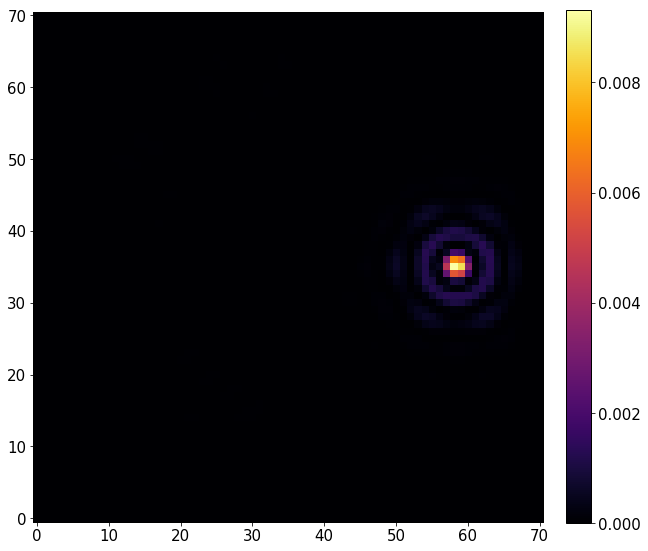

In [5]:
plt.figure(figsize=(10,10))
plt.imshow(offset_psfs_mwav[-1,:,:],cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)

## Verify that flux is conserved

In [6]:
print np.sum(offset_psfs_mwav[-1,:,:]),np.sum(offset_psfs[-1,:,:])

0.226544987239 0.226608209283


## Mask data and isolate top right hand quarter

The library of off-axis psfs is only computer for a quarter, and perfect symmetry is assumed everywhere else

Text(0.5,1,u'Off-axis position coverage map')

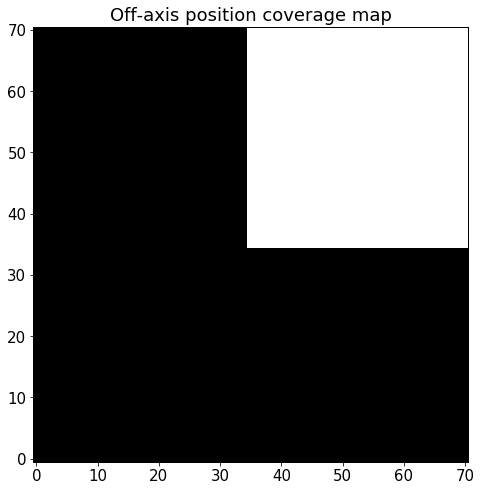

In [7]:
cx = scene_imw // 2
cy = scene_imw // 2
x_try = np.arange(cx, scene_imw)
y_try = np.arange(cy, scene_imw)

Nx = len(x_try)
Ny = len(y_try)

offax_pos_xpix, offax_pos_ypix = np.meshgrid(x_try, y_try)
xs_p = np.arange(scene_imw) - cx
ys_p = xs_p.copy()
xxs_p, yys_p = np.meshgrid(xs_p, ys_p)
rrs_p = np.sqrt(xxs_p**2 + yys_p**2)
data_mask_nan_ind = rrs_p >= 9. / pixscale_LoD
offax_pos_map = np.zeros((scene_imw, scene_imw))
xs_1d = np.round(np.ravel(offax_pos_xpix)).astype(np.int)
ys_1d = np.round(np.ravel(offax_pos_ypix)).astype(np.int)
offax_pos_map[ys_1d, xs_1d] = 1
plt.figure(figsize=(10,8))
plt.imshow(offax_pos_map)
plt.title('Off-axis position coverage map')

0.0


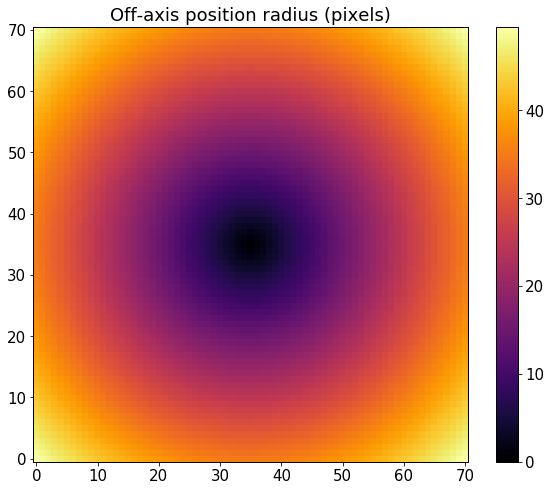

In [8]:
plt.figure(figsize=(10,8))
plt.imshow(rrs_p,cmap=cmap)
plt.title('Off-axis position radius (pixels)')
plt.colorbar()
print(rrs_p[cy, cx])

## Construct off-axis psf at every pixel in the quarter

Uses interpolation and shift functions

In [9]:
overwrite = True
offax_psf_fname = hlc_psf_path+'hlc_offax_psf_quad.fits'
if not os.path.exists(offax_psf_fname) or overwrite:
    psf_offax = np.zeros(((scene_imw//2 + 1)**2, scene_imw, scene_imw))
    for xi, x in enumerate(x_try):
        for yi, y in enumerate(y_try):
            jj = yi * (scene_imw // 2 + 1)  + xi
            r_LoD = rrs_p[x, y] * pixscale_LoD # destination radius
            theta = np.rad2deg(np.arctan2(y - cy, x - cx)) # destination theta
            if r_LoD <= np.max(offsets_LoD):
                oi = np.argmin(np.abs(r_LoD - offsets_LoD)) # index of closest radial offset in Krist model array
                dr_LoD = r_LoD - offsets_LoD[oi] # radial shift needed in arcseconds
                dr_p = dr_LoD / pixscale_LoD # radial shift needed in pixels

                shift_offset_psf = \
                  scipy.ndimage.interpolation.shift(offset_psfs_mwav[oi],
                                                    (0, dr_p), order = 1,
                                                    cval=np.nan, prefilter=False)

                rot_shift_offset_psf = \
                  skimage.transform.rotate(shift_offset_psf, angle = -theta,
                                           order = 1, resize = False,
                                           center=(cy, cx), cval=np.nan)
                psf_offax[jj] = rot_shift_offset_psf
            else:
                psf_offax[jj, :, :] = np.nan

    psf_offax[:, data_mask_nan_ind] = np.nan
    
    fits.writeto(offax_psf_fname, psf_offax, overwrite=True)
    fits.append(offax_psf_fname, offax_pos_xpix, overwrite=True)
    fits.append(offax_psf_fname, offax_pos_ypix, overwrite=True)
    fits.setval(offax_psf_fname, ext=1, keyword='EXTNAME', value='XPIX', comment='x position in pixels from lower left corner')
    fits.setval(offax_psf_fname, ext=2, keyword='EXTNAME', value='YPIX', comment='y position in pixels from lower left corner')

## Test off-axis

36
10


Text(0.5,1,u'Haystacks scene in counts per 100.0 s, \n after coronagraph, w/o noise, w/o star')

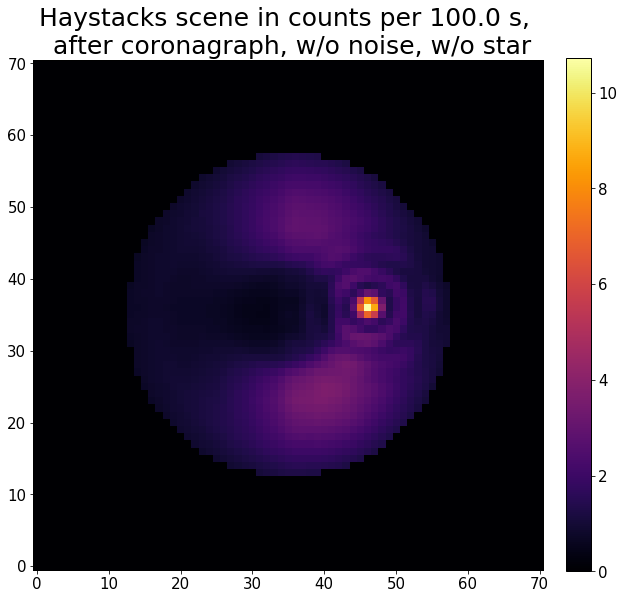

In [126]:
from crispy.tools.cgi import xy_to_psf

haystacks_path = '/Users/mrizzo/IFS/crispy/crispy/Inputs/'
haystacks_fname = os.path.join(haystacks_path,'BertrandCube.fits.gz')
hay_cube_bandavg_ph = fits.open(haystacks_fname)[0].data[1] * u.count/u.s
hay_cube_bandavg_ph = hay_cube_bandavg_ph

losses = 0.566 * 0.9 # from Bijan's spreadsheet, does not include PSF throughput (that's in the PSFs directly)
hay_cube_bandavg_ph *= losses
ply,plx = 36,46
fudge = 0.0 # accounts for dQE and stuff
hay_cube_bandavg_ph[35,47]=  hay_cube_bandavg_ph[ply,plx].copy()
# hay_cube_bandavg_ph[ply,plx] *= fudge


# The user may choose to dim the planet at will by multiplying that pixel by a constant

test_scene = np.zeros((scene_imw, scene_imw)) * u.count
# this selects a frame within the cube
exptime = 100*u.s
# pseudo-convolution
for x in range(scene_imw):
    for y in range(scene_imw):
        if x != cx and y != cx:
            test_scene += hay_cube_bandavg_ph[y,x] * np.nan_to_num(xy_to_psf(x, y, psf_offax)) * exptime
plt.figure(figsize=(10,10))
plt.imshow(test_scene.value,cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Haystacks scene in counts per %s, \n after coronagraph, w/o noise, w/o star' % exptime,fontsize=25)

# Process on-axis PSF

## Load

In [12]:
hlc_psf_path = '/Users/mrizzo/IFS/OS6/'
timesteps_fname = os.path.join(hlc_psf_path, 'hlc_os6/os6_timesteps.txt')
timesteps = np.loadtxt(timesteps_fname,skiprows=1)

print timesteps.shape
startype = timesteps[:,0]
timestep = timesteps[:,1]
exptime = timesteps[:,2]
roll = timesteps[:,3]
flux = timesteps[:,4]

(3630, 5)


## Test

(3630, 200, 200)
7.5099611422e-05


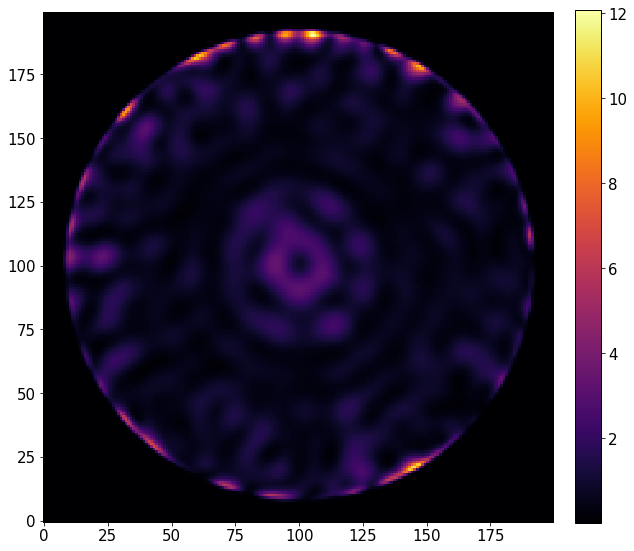

In [13]:
data = fits.getdata(psf_series_47UMa_fname).astype(np.float)
print data.shape

plt.figure(figsize=(10,10))
plt.imshow(data[0],cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)
print data[0,0,0]

## Rescale on-axis psf

In [14]:
from crispy.tools.detutils import frebin
rescaled_data = np.zeros((data.shape[0], scene_imw, scene_imw))

test_scaled_data = skimage.transform.rescale(data[0],
                                                   (s, s), order=interp_order,
                                                   cval=0) / s**2
# test_scaled_data = frebin(data[0],(scene_imw, scene_imw))

if test_scaled_data.shape[-1] % 2 == 1:
    padded_data = data.copy()
else: # need to pad the array in order to make the scaled width odd
    padded_data = np.pad(data, ((0,0), (2,2), (2,2)),
                                mode='constant')

for i in range(data.shape[0]):
    scaled_data = skimage.transform.rescale(padded_data[i],
                                                   (s, s), order=interp_order,
                                                   cval=0) / s**2
#     scaled_data = frebin(padded_data[i],(scene_imw, scene_imw))
    assert(scaled_data.shape[-1] % 2 == 1) # array width must be odd
    zpw = (scene_imw - scaled_data.shape[-1]) // 2
    if zpw > 0:
        rescaled_data[i, zpw:-zpw, zpw:-zpw] = scaled_data
    elif zpw < 0:
        rescaled_data[i, :, :] = scaled_data[-zpw:zpw, -zpw:zpw]
    else:
        rescaled_data[i, :, :] = scaled_data

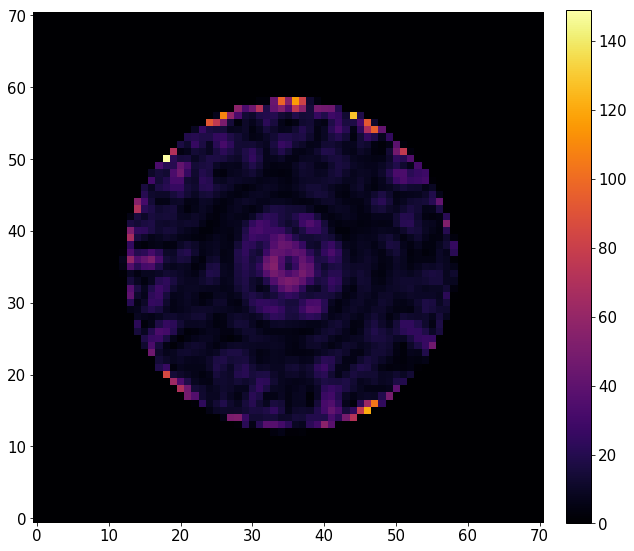

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(rescaled_data[0],cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)


## Export

In [16]:
onaxis_psf_name = hlc_psf_path+'hlc_psf_onax.fits.gz'
fits.writeto(onaxis_psf_name, rescaled_data, overwrite=True)

saturation for image pixel: 80000
saturation for the em register pixels: 730000

# Apply detector readout model to all files

In [16]:
from crispy.tools.detector import readoutPhotonFluxMapWFIRST as readoutWFIRST
reference = []
target_roll_plus = []
target_roll_minus = []
for i in range(data.shape[0]):
    if i%1000==0: print i
    obs = readoutWFIRST(rescaled_data[i]/exptime[i],
                                                tottime=exptime[i],
                                                inttime=exptime[i],
                                                PCcorrect=False, # don't correct for photon counting bias
                                                PCmode = False,
                                                crrate = 0.0,
                                                hprate=0.0,
                                                lifefraction=0.5,
                                                xs=100,ys=100,
                                                QE = 0.9,
                                                ).astype(np.int)
    if startype[i]==1:
        reference += [obs]
    elif roll[i]==1 or roll[i]==3:
        target_roll_minus += [obs]
    else:
        target_roll_plus += [obs]

0
1000
2000
3000


In [17]:
target_roll_p = np.nanmean(np.array(target_roll_plus).astype(np.float),axis=0)
target_roll_m = np.nanmean(np.array(target_roll_minus).astype(np.float),axis=0)
ref = np.nanmean(np.array(reference).astype(np.float),axis=0)
print np.array(target_roll_plus).shape
print np.array(reference).shape
print np.array(target_roll_minus).shape

(1430, 71, 71)
(770, 71, 71)
(1430, 71, 71)


## Plot results

284276.762338
15025.3951049


Text(0.5,1,u'Target Roll Minus')

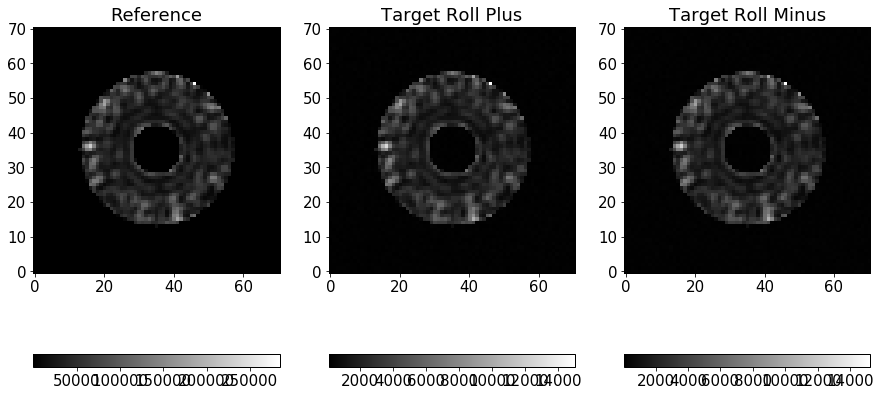

In [18]:
plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(ref)
print np.amax(ref)
plt.colorbar(orientation='horizontal')
plt.title('Reference')
plt.subplot(132)
plt.imshow(target_roll_p)
plt.title('Target Roll Plus')

print np.amax(target_roll_p)

plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.imshow(target_roll_m)
plt.colorbar(orientation='horizontal')
plt.title('Target Roll Minus')


## Simple RDI

(1452,)


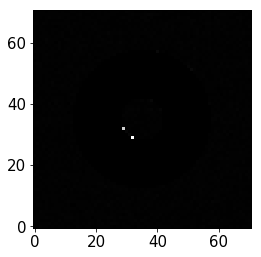

In [19]:
xindx = np.arange(scene_imw)-scene_imw//2
xindx,yindx = np.meshgrid(xindx,xindx)
r = np.sqrt(xindx**2+yindx**2)
mask = (r>2.7/pixscale_LoD)*(r<9./pixscale_LoD)
plt.imshow(ref*~mask)
print target_roll_p[mask].shape
refslice = ref[mask]
targetslice = target_roll_p[mask]
import scipy
b, a, _, _, _ = scipy.stats.linregress(refslice, targetslice)
est = a + b * ref


## Plot RDI results

146.831942783 0.0522709965115
212.61923042


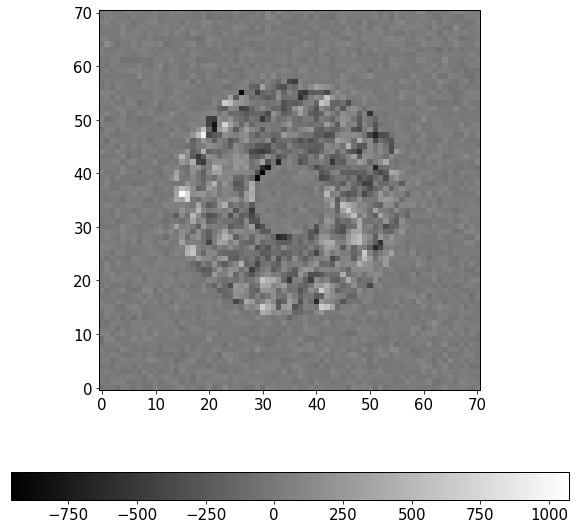

In [20]:
res = target_roll_p-est
plt.figure(figsize=(10,10))
plt.imshow(res)
plt.colorbar(orientation='horizontal')
print a,b
print np.std(res[mask])

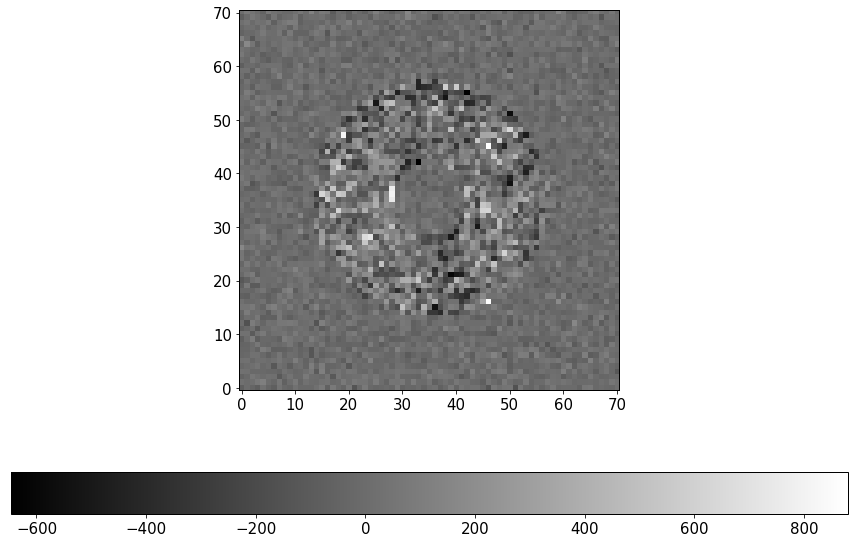

In [21]:
plt.figure(figsize=(15,10))
plt.imshow(target_roll_p-target_roll_m)
plt.colorbar(orientation='horizontal')


# Fancy RDI

## Divide data into separate chunks

In [22]:
Ndat_in_chunk = 55 # number of frames in a single chunk
datsize = timesteps.shape[0]
reference_chunks_ind = []
roll_plus_chunks_ind = []
roll_minus_chunks_ind = []
print datsize/Ndat_in_chunk

# cut into chunks
chunks_ind = np.split(np.arange(datsize),datsize/Ndat_in_chunk)

# assign chunks
for j in range(len(chunks_ind)):
    i = chunks_ind[j][0]
    if startype[i]==1: reference_chunks_ind.append(chunks_ind[j])
    elif roll[i]==1 or roll[i]==3: roll_minus_chunks_ind.append(chunks_ind[j])
    else: roll_plus_chunks_ind.append(chunks_ind[j])


66


In [23]:
print 'Summary:'
print 'There are %d reference chunks' % len(reference_chunks_ind)
print 'There are %d target chunks with minus 13deg roll' % len(roll_minus_chunks_ind)
print 'There are %d target chunks with plus 13deg roll' % len(roll_plus_chunks_ind)


Summary:
There are 14 reference chunks
There are 26 target chunks with minus 13deg roll
There are 26 target chunks with plus 13deg roll


In [24]:
reference_chunks_ind[13][45]

3620

## Readout individual chunks

In [25]:
from crispy.tools.detector import readoutPhotonFluxMapWFIRST as readoutWFIRST
reference_data_average = []
for j in range(len(reference_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(reference_chunks_ind[j])):
        ind = reference_chunks_ind[j][i]
        obs = readoutWFIRST(rescaled_data[ind]/exptime[ind],
                                                tottime=exptime[ind],
                                                inttime=exptime[ind],
                                                PCcorrect=False, # don't correct for photon counting bias
                                                PCmode = False,
                                                crrate = 0.0,
                                                hprate=0.0,
                                                lifefraction=0.5,
                                                xs=100,ys=100,
                                                QE = 0.9,
                                                ).astype(np.int)
        chunk_indiv_frame.append(obs)
    reference_data_average.append(np.nanmean(np.array(chunk_indiv_frame),axis=0))

roll_minus_data_average = []
for j in range(len(roll_minus_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(roll_minus_chunks_ind[j])):
        ind = roll_minus_chunks_ind[j][i]
        obs = readoutWFIRST(rescaled_data[ind]/exptime[ind],
                                                tottime=exptime[ind],
                                                inttime=exptime[ind],
                                                PCcorrect=False, # don't correct for photon counting bias
                                                PCmode = False,
                                                crrate = 0.0,
                                                hprate=0.0,
                                                lifefraction=0.5,
                                                xs=100,ys=100,
                                                QE = 0.9,
                                                ).astype(np.int)
        chunk_indiv_frame.append(obs)
    roll_minus_data_average.append(np.nanmean(np.array(chunk_indiv_frame),axis=0))

roll_plus_data_average = []
for j in range(len(roll_plus_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(roll_plus_chunks_ind[j])):
        ind = roll_plus_chunks_ind[j][i]
        obs = readoutWFIRST(rescaled_data[ind]/exptime[ind],
                                                tottime=exptime[ind],
                                                inttime=exptime[ind],
                                                PCcorrect=False, # don't correct for photon counting bias
                                                PCmode = False,
                                                crrate = 0.0,
                                                hprate=0.0,
                                                lifefraction=0.5,
                                                xs=100,ys=100,
                                                QE = 0.9,
                                                ).astype(np.int)
        chunk_indiv_frame.append(obs)
    roll_plus_data_average.append(np.nanmean(np.array(chunk_indiv_frame),axis=0))


In [26]:
print len(reference_data_average)
from astropy.io import fits
fits.writeto(hlc_psf_path+'references.fits',np.array(reference_data_average)/5000., overwrite=True)
fits.writeto(hlc_psf_path+'roll_minus.fits',np.array(roll_minus_data_average)/5000., overwrite=True)
fits.writeto(hlc_psf_path+'roll_plus.fits',np.array(roll_plus_data_average)/5000., overwrite=True)


14


## Construct data mask

In [26]:
x_try = np.arange(scene_imw)
y_try = np.arange(scene_imw)

x_try, y_try = np.meshgrid(x_try, y_try)
xs_p = np.arange(scene_imw) - cx
ys_p = xs_p.copy()
xxs_p, yys_p = np.meshgrid(xs_p, ys_p)
rrs_p = np.sqrt(xxs_p**2 + yys_p**2)
data_select = np.logical_or(rrs_p >= 9. / pixscale_LoD,rrs_p <= 2.8 / pixscale_LoD)
data_mask = np.where(np.equal(~data_select, 1), 1, np.nan)



array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

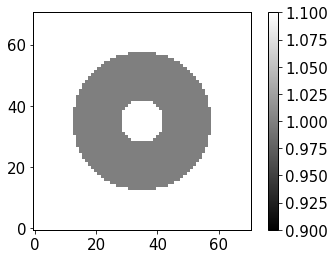

In [28]:
plt.imshow(data_mask)
plt.colorbar()
data_mask

## Define vectorizing functions to prepare the data for RDI

In [20]:
def vectorize_image_series(image_series, data_mask_nan):
    data_ind = np.where( ~np.isnan(data_mask_nan) )
    nan_ind = np.where( np.isnan(data_mask_nan) )
    N_pix = len(data_ind[0])
    N_mask = len(nan_ind[0])
    vec_series = image_series[:,data_ind[0],data_ind[1]]
    
    return vec_series, data_ind, nan_ind, N_pix, N_mask

In [21]:
def reconstruct_image_series(vec_series, data_ind, nan_ind, height, width):
    N_pix = len(data_ind[0])
    N_mask = len(nan_ind[0])
    reconst_cube = np.zeros((vec_series.shape[0], height, width))
    for i in range(N_pix):
        reconst_cube[:,data_ind[0][i],data_ind[1][i]] = vec_series[:,i]
    for i in range(N_mask):
        reconst_cube[:,nan_ind[0][i],nan_ind[1][i]] = np.nan
        
    return reconst_cube

In [31]:
data_ind = np.where(~np.isnan(data_mask) )
print data_ind
print np.array(reference_data_average).shape

(array([13, 13, 13, ..., 57, 57, 57]), array([31, 32, 33, ..., 37, 38, 39]))
(14, 71, 71)


## Vectorize the reference frames

In [32]:
ref_series = np.array(reference_data_average)
target_series = np.array(roll_minus_data_average)
print target_series.shape
ref_vec_series, data_ind, nan_ind, N_pix, N_mask = vectorize_image_series(ref_series,data_mask)

(26, 71, 71)


## Define RDI function, no throuput determination

In [22]:
def get_trunc_KL_basis(R, K):
    U, sv, Vt = np.linalg.svd(R, full_matrices=False)
    N_modes = min([K, Vt.shape[0]])
    return Vt[:N_modes, :], sv, N_modes

def rdi_klipsub(R, T, Kcut): 
    # perform KLIP RDI subtraction with Kcut modes
    # R is the reference vector array; N_ref_frame rows and N_pix columns
    # T is the target vector array; 1 row and N_pix columns

    # Subtract spatial mean from each image vector
    R_smean = np.tile(np.reshape(np.mean(R, axis=1),(R.shape[0],1)), (1, R.shape[1]))
    Rs = R - R_smean
    T_smean = np.tile(np.mean(T, axis=1), (1, T.shape[1]))
    Ts = T - T_smean

    # Get K-L basis
    Z, sv, K = get_trunc_KL_basis(Rs, Kcut)
    # Project target and subtract
    S = Ts - Ts.dot(Z.T).dot(Z)

    return S


## Vectorize the target frame

In [34]:
data_ind = np.where( ~np.isnan(data_mask) )
target_vec = target_series[0,data_ind[0],data_ind[1]].reshape((1,-1))
print target_vec.shape

(1, 1452)


## Do RDI

In [35]:
S = rdi_klipsub(ref_vec_series,target_vec,10)

## Reconstruct the residuals

In [36]:
res = reconstruct_image_series(S,data_ind, nan_ind, scene_imw, scene_imw)

## Plot

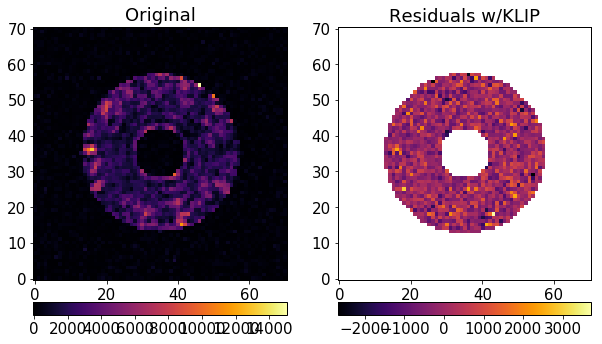

In [37]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('Original')
plt.imshow(target_series[0],cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.subplot(122)
plt.title('Residuals w/KLIP')
plt.imshow(res[0],cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)


# RDI analysis on whole dataset

## Compute correlation matrix function

In [23]:
def get_correlation_matrix(data_vec_series):
    Nt = data_vec_series.shape[0]
    corr_matx = np.zeros((Nt, Nt))
    for ti in range(Nt):
        for tj in range(ti+1):
            corrcoef_matx = np.corrcoef(data_vec_series[ti], data_vec_series[tj])
            corr_matx[ti, tj] = corrcoef_matx[0][1]
            corr_matx[tj, ti] = corr_matx[ti, tj]

    return corr_matx

## Get RMS stability function

In [24]:
def get_rms_stability_map(cube, samps_X, samps_Y):
    rms_map = np.std(cube, axis=0)
    samp_rms_map = np.empty_like(samps_X)
    Ni = samp_rms_map.shape[0]
    Nj = samp_rms_map.shape[1]
    for ii in range(Ni):
        for jj in range(Nj):
            samp_rms_map[ii,jj] = np.std(cube[:, int(round(samps_Y[ii,jj])), int(round(samps_X[ii,jj]))])
    return rms_map, samp_rms_map

## Vectorize all target data

In [40]:
target_vec_series, data_ind, nan_ind, Np, Nexc = vectorize_image_series(target_series, data_mask)
print target_vec_series.shape

(26, 1452)


## Concatenate data and get correlation matrix

In [41]:
Nref = ref_series.shape[0]
all_vec_series = np.concatenate([ref_vec_series, target_vec_series], axis=0)
raw_corr_matx = get_correlation_matrix(all_vec_series)

peak_corr = np.max( raw_corr_matx[Nref:, :Nref], axis=1 )
peak_corr_ref_ind = np.argmax( raw_corr_matx[Nref:, :Nref], axis=1 )
corr_sort_ind = np.argsort(peak_corr)[::-1]
predic_gain = 1./np.sqrt(1/peak_corr**2 - 1)

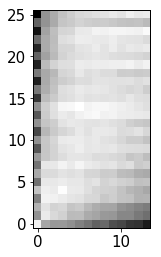

In [42]:
plt.imshow(raw_corr_matx[Nref:, :Nref])

## PSF subtraction loop

In [43]:
Ntarget = target_series.shape[0]

classicsub_s_cube = np.zeros((Ntarget, scene_imw, scene_imw))
refLSQ_s_cube = np.zeros((Ntarget, scene_imw, scene_imw))
klipsub_s_cube = np.zeros((Ntarget, scene_imw, scene_imw))

classicsub_s_vec = np.zeros((Ntarget, Np))
refLSQ_s_vec = np.zeros((Ntarget, Np))

Ktest = 5

for ii in range(Ntarget):
    b, a, _, _, _ = scipy.stats.linregress(ref_vec_series[ peak_corr_ref_ind[ii] ], target_vec_series[ii])
    classic_est_vec = a + b*ref_vec_series[ peak_corr_ref_ind[ii] ]
    classicsub_s_vec[ii] = target_vec_series[ii] - classic_est_vec
        
    R = ref_vec_series.copy()
    T = np.reshape(target_vec_series[ii],(1, -1))
    R_smean = np.tile(np.reshape(np.mean(R, axis=1),(R.shape[0],1)), (1, R.shape[1]))
    Rs = R - R_smean
    T_smean = np.tile(np.mean(T, axis=1), (1, T.shape[1]))
    Ts = T - T_smean
    Xhat_refLSQ = Ts.dot(np.linalg.pinv(Rs)).dot(Rs)
    refLSQ_s_vec[ii] = Ts - Xhat_refLSQ
    
    # get klip-subtracted vectors over the range of K values
    target_s_vec = target_vec_series[ii].reshape((1,-1))
    klipsub_s_vec = rdi_klipsub(ref_vec_series, target_s_vec, Ktest)
    
    # reconstruct KLIP residual
    klipsub_s_cube[ii] = reconstruct_image_series(klipsub_s_vec, data_ind, nan_ind, scene_imw, scene_imw)
    
classicsub_s_cube = reconstruct_image_series(classicsub_s_vec, data_ind, nan_ind, scene_imw, scene_imw)
refLSQ_s_cube = reconstruct_image_series(refLSQ_s_vec, data_ind, nan_ind, scene_imw, scene_imw)


## Plot results

##############################
RMS in the dark hole residuals
##############################
Classical:  717.82819027
Least Squares:  708.334211235
KLIP:  710.581084347


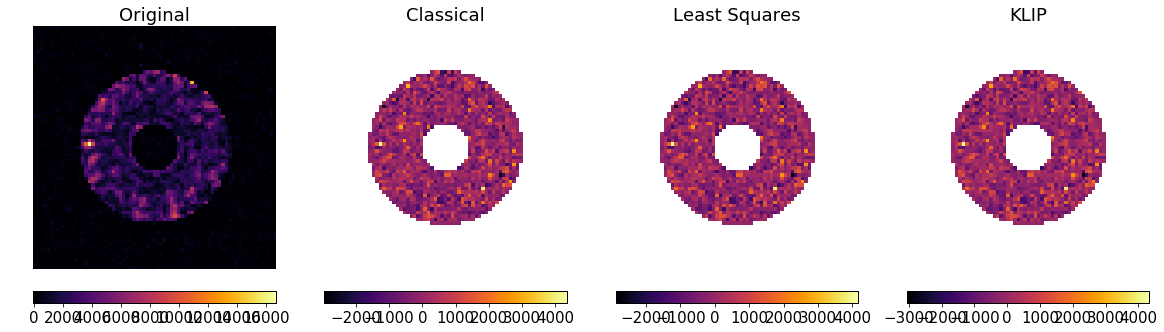

In [44]:
slice_select = -1

plt.figure(figsize=(20,10))
plt.subplot(141)
plt.title('Original')
plt.imshow(target_series[slice_select],cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.axis('off')
plt.subplot(142)
plt.title('Classical')
plt.imshow(classicsub_s_cube[slice_select],cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.axis('off')
plt.subplot(143)
plt.title('Least Squares')
plt.imshow(refLSQ_s_cube[slice_select],cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.axis('off')
plt.subplot(144)
plt.title('KLIP')
plt.imshow(klipsub_s_cube[slice_select],cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.axis('off')

print '##############################'
print 'RMS in the dark hole residuals'
print '##############################'
print 'Classical: ',np.nanstd(classicsub_s_cube[slice_select])
print 'Least Squares: ',np.nanstd(refLSQ_s_cube[slice_select])
print 'KLIP: ',np.nanstd(klipsub_s_cube[slice_select])

# Correlation matrix over whole dataset

## Compute chunk averages but keep time order

In [45]:
chunks_ind = np.split(np.arange(datsize),datsize/Ndat_in_chunk)
print "Number of chunks:",len(chunks_ind)

data_average = []
for j in range(len(chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(chunks_ind[j])):
        ind = chunks_ind[j][i]
        obs = readoutWFIRST(rescaled_data[ind]/exptime[ind],
                                                tottime=exptime[ind],
                                                inttime=exptime[ind],
                                                PCcorrect=False, # don't correct for photon counting bias
                                                PCmode = False,
                                                crrate = 0.0,
                                                hprate=0.0,
                                                lifefraction=0.5,
                                                xs=100,ys=100,
                                                QE = 0.9,
                                                ).astype(np.int)
        chunk_indiv_frame.append(obs)
    data_average.append(np.nanmean(np.array(chunk_indiv_frame),axis=0))


Number of chunks: 66


In [46]:
data_average = np.array(data_average)

In [47]:
print data_average.shape

(66, 71, 71)


## Vectorize all chunks

In [48]:
data_average_vec, data_ind, nan_ind, N_pix, N_mask = vectorize_image_series(data_average,data_mask)

## Calculate correlation

In [206]:
raw_corr_matx = get_correlation_matrix(data_average_vec)
plt.figure(figsize=(10,10))
plt.title('Data correlation')
plt.imshow(raw_corr_matx,cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig('/Users/mrizzo/Downloads/Data_Corr.png',dpi=300)

NameError: name 'data_average_vec' is not defined

# Re-process files with enhanced detector

1. Adjust exposure times to modest levels (<0.1 electron per pixel per frame for high percentiles)
2. Add hot pixels
3. Subtract a well-averaged dark frame
4. If possible, add cosmic rays and remove them by looking at the average in each chunk

## Practice with a single image

### Plot

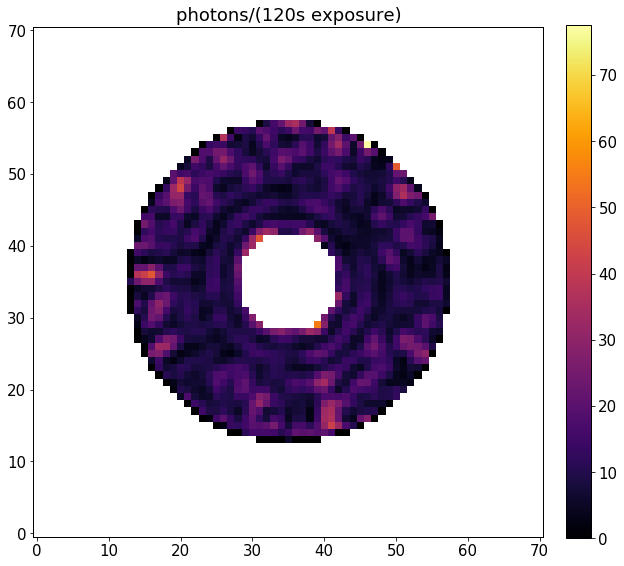

In [71]:
ind = 10
img = rescaled_data[ind]
img[np.where(np.isnan(data_mask) )] = np.nan
plt.figure(figsize=(10,10))
plt.title('photons/(120s exposure)')
plt.imshow(img,cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)


### Calculate percentile

13.9129751042


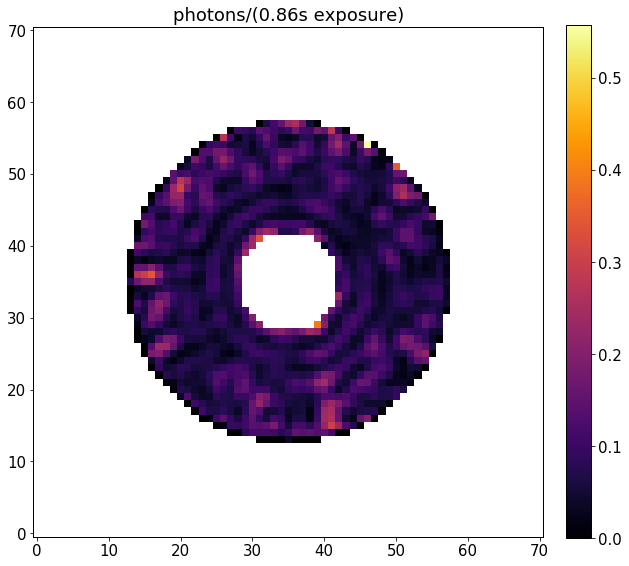

In [72]:
percent = np.nanpercentile(img,70)
print percent
plt.figure(figsize=(10,10))
plt.title('photons/(%.2fs exposure)' % (120*0.1/percent))
plt.imshow(img*0.1/percent,cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)


### Apply readout

In [57]:
img = np.pad(rescaled_data[ind],pad_width=((100,100),(100,100)),mode='constant')

obs = readoutWFIRST(img/120.,
                        tottime=120.,
                        inttime=10.,
                        PCcorrect=False, # don't correct for photon counting bias
                        PCmode = False,
                        EMGain = 1000.,
                        crrate = 5.0,
                        hprate=3.0,
                        lifefraction=0.5,
                        xs=500,ys=500,
                        QE = 0.9,
                        verbose=True,
                        )


Number of reads: 12
154 dark counts per exposure
2500 CIC counts per exposure
6 cosmic rays per exposure
25 hot pixel counts per exposure


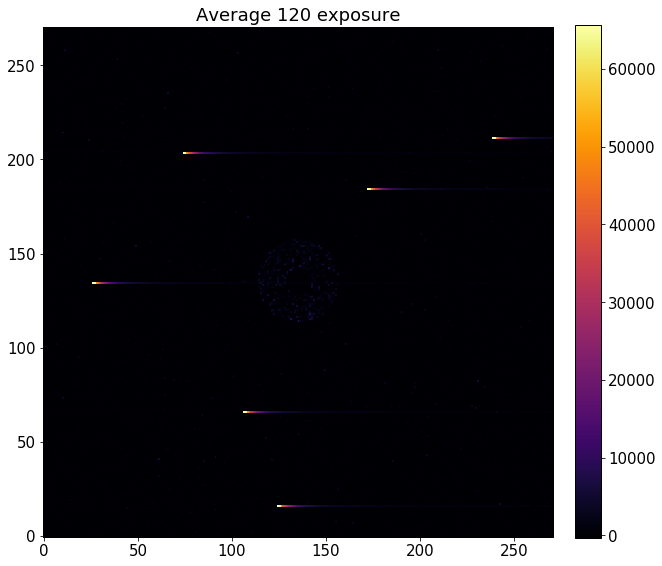

In [58]:
plt.figure(figsize=(10,10))
plt.title('Average 120 exposure')
plt.imshow(obs[0],cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)
fits.writeto('/Users/mrizzo/Downloads/obs.fits', obs, overwrite=True)

### Practice cosmic ray removal

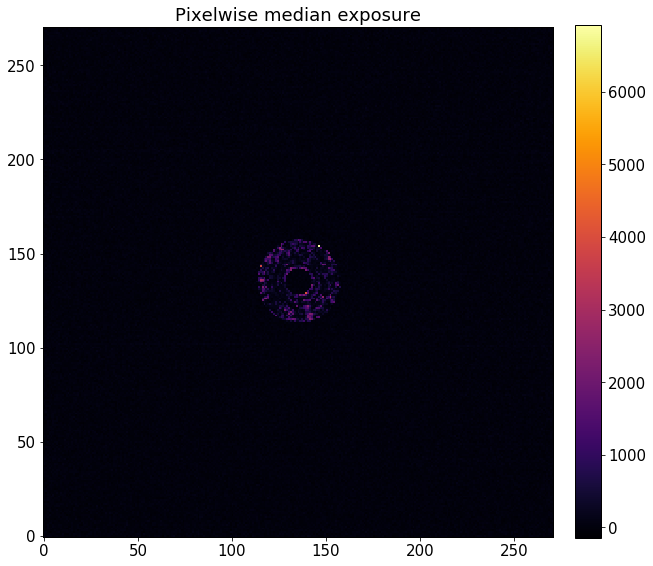

In [59]:
noCR = np.median(obs,axis=0)
plt.figure(figsize=(10,10))
plt.title('Pixelwise median exposure')
plt.imshow(noCR,cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)
fits.writeto('/Users/mrizzo/Downloads/obs_noCR.fits',noCR, overwrite=True)

In [ ]:
new = np.concatenate((obs,obs),axis=0)
print new.shape

### Test Astropy sigma-clipping method

This returns a masked array, not the most convenient for right now

(12, 271, 271)


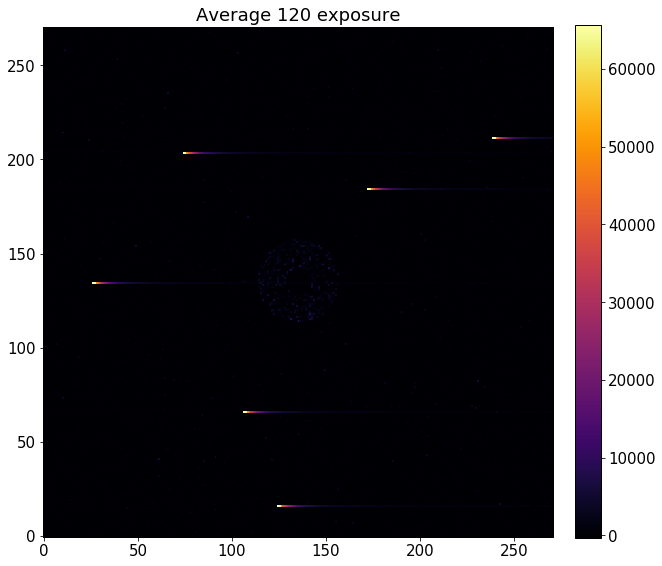

In [61]:
from astropy.stats import sigma_clip
newobs = sigma_clip(obs,sigma_lower=5, sigma_upper=5,iters=5,axis=0)
print newobs.shape
plt.figure(figsize=(10,10))
plt.title('Average 120 exposure')
plt.imshow(newobs[0],cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)
fits.writeto('/Users/mrizzo/Downloads/newobs.fits', newobs.data, overwrite=True)

### create dark frame

Number of reads: 1000
154 dark counts per exposure
2500 CIC counts per exposure
0 cosmic rays per exposure
25 hot pixel counts per exposure


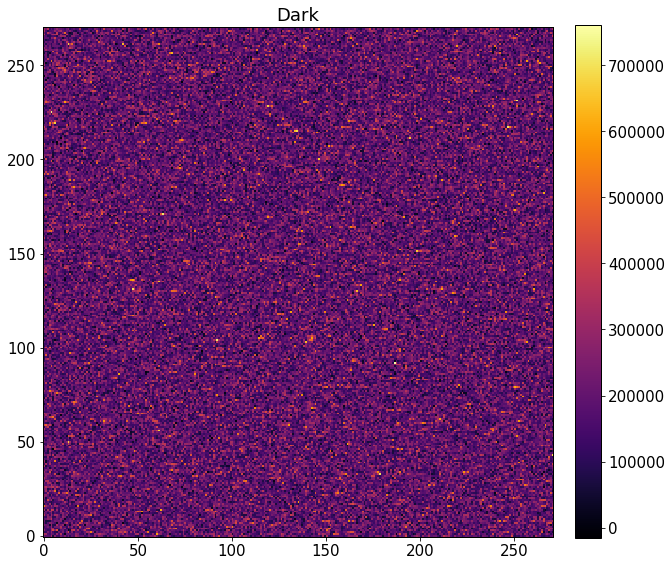

In [62]:
darkf = np.zeros_like(img)
dark = readoutWFIRST(darkf,
                        tottime=10000.,
                        inttime=10.,
                        PCcorrect=False, # don't correct for photon counting bias
                        PCmode = False,
                        EMGain = 4000.,
                        crrate = 0.0,
                        hprate=3.0,
                        lifefraction=0.5,
                        xs=500,ys=500,
                        QE = 0.9,
                        verbose=True,
                        )
sumdark = np.mean(dark,axis=0)
plt.figure(figsize=(10,10))
plt.title('Dark')
plt.imshow(sumdark,cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)
fits.writeto('/Users/mrizzo/Downloads/sumdark.fits', sumdark, overwrite=True)

## Process stack

### Divide into chunks

In [229]:
Ndat_in_chunk = 55 # number of frames in a single chunk
datsize = timesteps.shape[0]
reference_chunks_ind = []
roll_plus_chunks_ind = []
roll_minus_chunks_ind = []
print datsize/Ndat_in_chunk

# cut into chunks
chunks_ind = np.split(np.arange(datsize),datsize/Ndat_in_chunk)

# assign chunks
for j in range(len(chunks_ind)):
    i = chunks_ind[j][0]
    if startype[i]==1: reference_chunks_ind.append(chunks_ind[j])
    elif roll[i]==1 or roll[i]==3: roll_minus_chunks_ind.append(chunks_ind[j])
    else: roll_plus_chunks_ind.append(chunks_ind[j])


print 'Summary:'
print 'There are %d reference chunks' % len(reference_chunks_ind)
print 'There are %d target chunks with minus 13deg roll' % len(roll_minus_chunks_ind)
print 'There are %d target chunks with plus 13deg roll' % len(roll_plus_chunks_ind)


66


TypeError: 'function' object has no attribute '__getitem__'

### Construct data mask

In [ ]:
x_try = np.arange(scene_imw)
y_try = np.arange(scene_imw)

x_try, y_try = np.meshgrid(x_try, y_try)
xs_p = np.arange(scene_imw) - cx
ys_p = xs_p.copy()
xxs_p, yys_p = np.meshgrid(xs_p, ys_p)
rrs_p = np.sqrt(xxs_p**2 + yys_p**2)
data_select = np.logical_or(rrs_p >= 9. / pixscale_LoD,rrs_p <= 2.8 / pixscale_LoD)
data_mask = np.where(np.equal(~data_select, 1), 1, np.nan)


### Readout everything

Ignore saturation effects for now, everything has the same gain

#### First reference image and dark to initialize the stack

In [130]:
from crispy.tools.detector import readoutPhotonFluxMapWFIRST as readoutWFIRST

EMGain = 4000
ind=0
img = np.pad(rescaled_data[ind],pad_width=((75,75),(75,75)),mode='constant')
inttime_ref = 10.
inttime_target = 60.
obs = readoutWFIRST(img/exptime[ind],
                    tottime=exptime[ind],
                    inttime=inttime_ref,
                    PCcorrect=False, # don't correct for photon counting bias
                    PCmode = False,
                    EMGain=4000.,
                    crrate = 5.0,
                    hprate=3.0,
                    lifefraction=0.5,
                    xs=300,ys=300,
                    QE = 0.9,
                    verbose=True
                    ).astype(np.int)
fits.writeto('/Users/mrizzo/IFS/OS6/Results/os6_%d.fits' % 0, obs, overwrite=True)

dark_ref = readoutWFIRST(np.zeros_like(img),
                    tottime=1000*inttime_ref,
                    inttime=inttime_ref,
                    PCcorrect=False, # don't correct for photon counting bias
                    PCmode = False,
                    EMGain=4000.,
                    crrate = 0.0,
                    hprate=3.0,
                    lifefraction=0.5,
                    xs=300,ys=300,
                    QE = 0.9,
                    verbose=True
                    ).astype(np.int)
fits.writeto('/Users/mrizzo/IFS/OS6/Results/os6_dark_%ds.fits' % inttime_ref, dark_ref, overwrite=True)

dark_target = readoutWFIRST(np.zeros_like(img),
                    tottime=1000*inttime_target,
                    inttime=inttime_target,
                    PCcorrect=False, # don't correct for photon counting bias
                    PCmode = False,
                    EMGain=4000.,
                    crrate = 0.0,
                    hprate=3.0,
                    lifefraction=0.5,
                    xs=300,ys=300,
                    QE = 0.9,
                    verbose=True
                    ).astype(np.int)
fits.writeto('/Users/mrizzo/IFS/OS6/Results/os6_dark_%ds.fits' % inttime_target, dark_target, overwrite=True)


Number of reads: 12
103 dark counts per exposure
900 CIC counts per exposure
4 cosmic rays per exposure
16 hot pixel counts per exposure
Number of reads: 1000
103 dark counts per exposure
900 CIC counts per exposure
0 cosmic rays per exposure
16 hot pixel counts per exposure
Number of reads: 1000
615 dark counts per exposure
900 CIC counts per exposure
0 cosmic rays per exposure
97 hot pixel counts per exposure


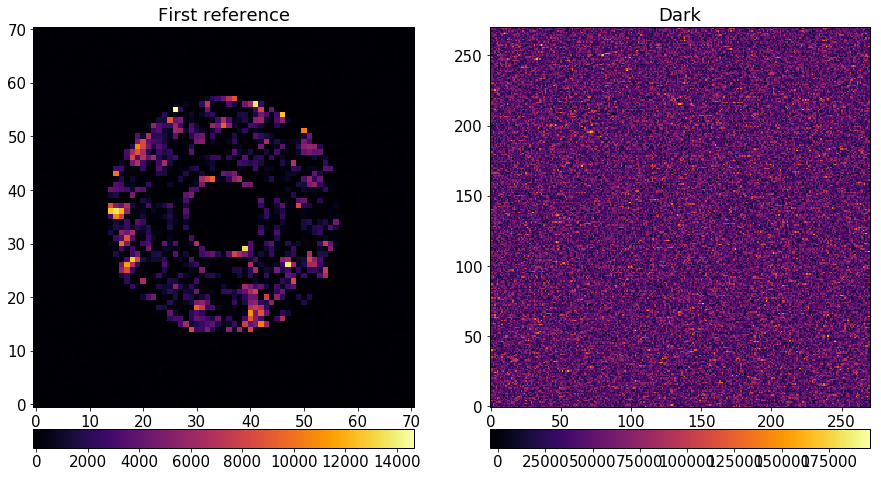

In [105]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.title('First reference')
firstref = np.median(obs,axis=0)-np.median(dark_ref,axis=0)
plt.imshow(firstref[100:-100,100:-100],cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.subplot(122)
plt.title('Dark')
plt.imshow(np.sum(dark_ref,axis=0),cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)

In [106]:
print obs.shape

(12, 271, 271)


#### Follow up with the rest by concatenating arrays

In [127]:
for j in range(1,len(rescaled_data)):
    if j%100==0: print(j)
    if startype[j]==1: inttime = inttime_ref
    else: inttime = inttime_target
    img = np.pad(rescaled_data[j],pad_width=((75,75),(75,75)),mode='constant')
    
    obs = readoutWFIRST(img/exptime[j],
                        tottime=exptime[j],
                        inttime=inttime,
                        PCcorrect=False, # don't correct for photon counting bias
                        PCmode = False,
                        EMGain=4000.,
                        crrate = 5.0,
                        hprate=3.0,
                        lifefraction=0.5,
                        xs=300,ys=300,
                        QE = 0.9,
                        ).astype(np.int)
    fits.writeto('/Users/mrizzo/IFS/OS6/Results/os6_%d.fits' % j, obs, overwrite=True)
#     obs = np.concatenate((obs,newobs),axis=0)

print obs.shape
# fits.writeto('/Users/mrizzo/Downloads/obs.fits', obs, overwrite=True)# reference_data_average = []
# for j in range(len(reference_chunks_ind)):
#     chunk_indiv_frame = []
#     for i in range(len(reference_chunks_ind[j])):
#         ind = reference_chunks_ind[j][i]
#         obs = readoutWFIRST(rescaled_data[ind]/exptime[ind],
#                                                 tottime=exptime[ind],
#                                                 inttime=exptime[ind],
#                                                 PCcorrect=False, # don't correct for photon counting bias
#                                                 PCmode = False,
#                                                 crrate = 0.0,
#                                                 hprate=0.0,
#                                                 lifefraction=0.5,
#                                                 xs=100,ys=100,
#                                                 QE = 0.9,
#                                                 ).astype(np.int)
#         chunk_indiv_frame.append(obs)
#     reference_data_average.append(np.nanmean(np.array(chunk_indiv_frame),axis=0))

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
(12, 221, 221)


### Now process the files we created

#### Define chunks again just to be sure

In [223]:
Ndat_in_chunk = 55 # number of frames in a single chunk
datsize = timesteps.shape[0]
reference_chunks_ind = []
roll_plus_chunks_ind = []
roll_minus_chunks_ind = []
print datsize/Ndat_in_chunk

# cut into chunks
chunks_ind = np.split(np.arange(datsize),datsize/Ndat_in_chunk)

# assign chunks
for j in range(len(chunks_ind)):
    i = chunks_ind[j][0]
    if startype[i]==1: reference_chunks_ind.append(chunks_ind[j])
    elif roll[i]==1 or roll[i]==3: roll_minus_chunks_ind.append(chunks_ind[j])
    else: roll_plus_chunks_ind.append(chunks_ind[j])


66


TypeError: 'function' object has no attribute '__getitem__'

#### Now average each chunk and separate into different observations

In [224]:
from crispy.tools.detector import readoutPhotonFluxMapWFIRST as readoutWFIRST
reference_data_average = []
for j in range(len(reference_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(reference_chunks_ind[j])):
        ind = reference_chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/Results/os6_%d.fits' % ind
        hdu = fits.open(fname)
        obs = hdu[0].data
        hdu.close()
        chunk_indiv_frame.append(obs)
    arr = np.array(chunk_indiv_frame)-np.mean(dark_ref,axis=0)[np.newaxis,np.newaxis,:,:]
    reference_data_average.append(np.nansum(np.nansum(arr,axis=0),axis=0)/np.prod(arr.shape[:2]))

roll_minus_data_average = []
for j in range(len(roll_minus_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(roll_minus_chunks_ind[j])):
        ind = roll_minus_chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/Results/os6_%d.fits' % ind
        hdu = fits.open(fname)
        obs = hdu[0].data
        hdu.close()
        chunk_indiv_frame.append(obs)
    arr = np.array(chunk_indiv_frame)-np.mean(dark_target,axis=0)[np.newaxis,np.newaxis,:,:]
    roll_minus_data_average.append(np.nansum(np.nansum(arr,axis=0),axis=0)/np.prod(arr.shape[:2]))

roll_plus_data_average = []
for j in range(len(roll_plus_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(roll_plus_chunks_ind[j])):
        ind = roll_plus_chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/Results/os6_%d.fits' % ind
        hdu = fits.open(fname)
        obs = hdu[0].data
        hdu.close()
        chunk_indiv_frame.append(obs)
    arr = np.array(chunk_indiv_frame)-np.mean(dark_target,axis=0)[np.newaxis,np.newaxis,:,:]
    roll_plus_data_average.append(np.nansum(np.nansum(arr,axis=0),axis=0)/np.prod(arr.shape[:2]))


#### Export

In [225]:
fits.writeto('/Users/mrizzo/IFS/OS6/references_haystacks.fits',np.array(reference_data_average), overwrite=True)
fits.writeto('/Users/mrizzo/IFS/OS6/roll_minus_haystacks.fits',np.array(roll_minus_data_average), overwrite=True)
fits.writeto('/Users/mrizzo/IFS/OS6/roll_plus_haystacks.fits',np.array(roll_plus_data_average), overwrite=True)


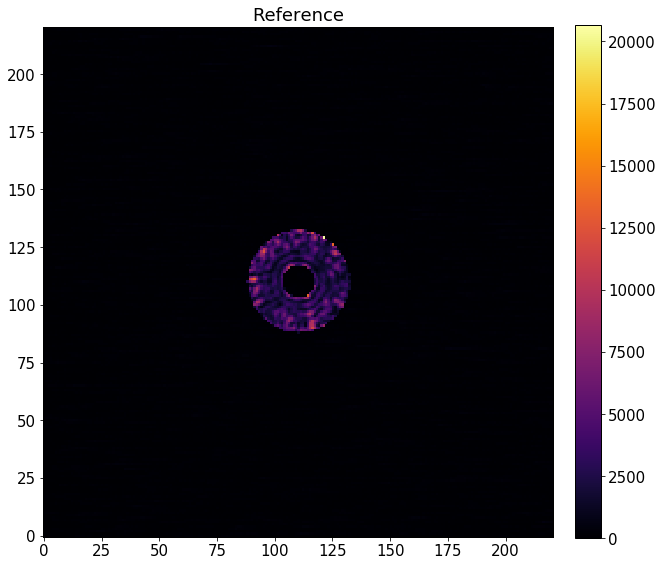

In [226]:
plt.figure(figsize=(10,10))
plt.title('Reference')
plt.imshow(ref[0],cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)


#### crop and combine

In [228]:
crop = 75
ref_series = np.array(reference_data_average)[:,crop:-crop,crop:-crop]
target_roll_minus_series = np.array(roll_minus_data_average)[:,crop:-crop,crop:-crop]
target_roll_plus_series = np.array(roll_plus_data_average)[:,crop:-crop,crop:-crop]
print ref_series.shape

ref_vec_series, data_ind, nan_ind, Np, Nexc = vectorize_image_series(ref_series, data_mask)
target_vec_minus_series, data_ind, nan_ind, Np, Nexc = vectorize_image_series(target_roll_minus_series, data_mask)
target_vec_plus_series, data_ind, nan_ind, Np, Nexc = vectorize_image_series(target_roll_plus_series, data_mask)

Nref = ref_series.shape[0]
# all_vec_series = np.concatenate([ref_vec_series, target_vec_minus_series, target_vec_plus_series], axis=0)
all_vec_series = np.concatenate([ref_vec_series, target_vec_minus_series], axis=0)

target_series = target_roll_minus_series
target_vec_series = target_vec_minus_series

IndexError: too many indices for array

In [178]:
print all_vec_series.shape

(40, 1452)


#### Find highest correlation

In [179]:
raw_corr_matx = get_correlation_matrix(all_vec_series)

peak_corr = np.max( raw_corr_matx[Nref:, :Nref], axis=1 )
peak_corr_ref_ind = np.argmax( raw_corr_matx[Nref:, :Nref], axis=1 )
corr_sort_ind = np.argsort(peak_corr)[::-1]
predic_gain = 1./np.sqrt(1/peak_corr**2 - 1)

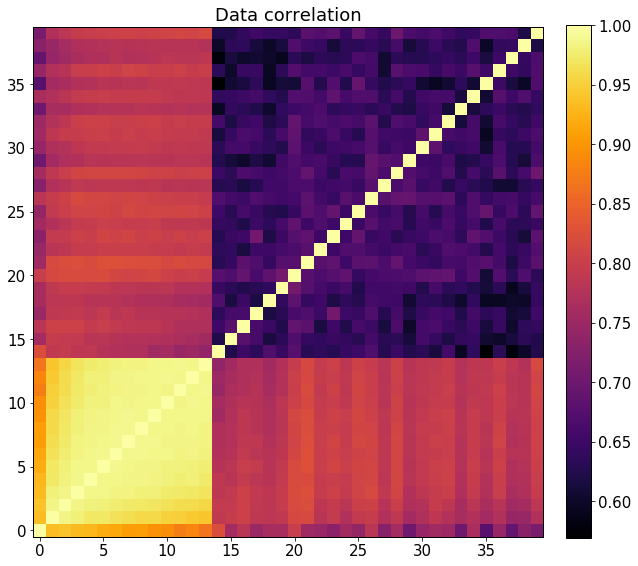

In [180]:
plt.figure(figsize=(10,10))
plt.title('Data correlation')
plt.imshow(raw_corr_matx,cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)


#### PSF subtraction loop

In [181]:
Ntarget = target_series.shape[0]

classicsub_s_cube = np.zeros((Ntarget, scene_imw, scene_imw))
refLSQ_s_cube = np.zeros((Ntarget, scene_imw, scene_imw))
klipsub_s_cube = np.zeros((Ntarget, scene_imw, scene_imw))

classicsub_s_vec = np.zeros((Ntarget, Np))
refLSQ_s_vec = np.zeros((Ntarget, Np))

Ktest = 5

for ii in range(Ntarget):
    b, a, _, _, _ = scipy.stats.linregress(ref_vec_series[ peak_corr_ref_ind[ii] ], target_vec_series[ii])
    classic_est_vec = a + b*ref_vec_series[ peak_corr_ref_ind[ii] ]
    classicsub_s_vec[ii] = target_vec_series[ii] - classic_est_vec
        
    R = ref_vec_series.copy()
    T = np.reshape(target_vec_series[ii],(1, -1))
    R_smean = np.tile(np.reshape(np.mean(R, axis=1),(R.shape[0],1)), (1, R.shape[1]))
    Rs = R - R_smean
    T_smean = np.tile(np.mean(T, axis=1), (1, T.shape[1]))
    Ts = T - T_smean
    Xhat_refLSQ = Ts.dot(np.linalg.pinv(Rs)).dot(Rs)
    refLSQ_s_vec[ii] = Ts - Xhat_refLSQ
    
    # get klip-subtracted vectors over the range of K values
    target_s_vec = target_vec_series[ii].reshape((1,-1))
    klipsub_s_vec = rdi_klipsub(ref_vec_series, target_s_vec, Ktest)
    
    # reconstruct KLIP residual
    klipsub_s_cube[ii] = reconstruct_image_series(klipsub_s_vec, data_ind, nan_ind, scene_imw, scene_imw)
    
classicsub_s_cube = reconstruct_image_series(classicsub_s_vec, data_ind, nan_ind, scene_imw, scene_imw)
refLSQ_s_cube = reconstruct_image_series(refLSQ_s_vec, data_ind, nan_ind, scene_imw, scene_imw)


##############################
RMS in the dark hole residuals
##############################
Classical:  415.376365277
Least Squares:  413.776914698
KLIP:  415.328345857


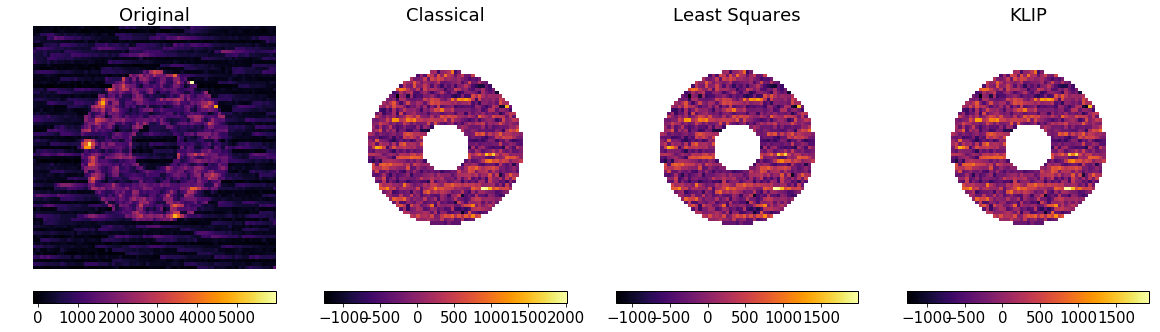

In [184]:
slice_select = -1

plt.figure(figsize=(20,10))
plt.subplot(141)
plt.title('Original')
plt.imshow(target_series[slice_select],cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.axis('off')
plt.subplot(142)
plt.title('Classical')
plt.imshow(classicsub_s_cube[slice_select],cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.axis('off')
plt.subplot(143)
plt.title('Least Squares')
plt.imshow(refLSQ_s_cube[slice_select],cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.axis('off')
plt.subplot(144)
plt.title('KLIP')
plt.imshow(klipsub_s_cube[slice_select],cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.axis('off')

print '##############################'
print 'RMS in the dark hole residuals'
print '##############################'
print 'Classical: ',np.nanstd(classicsub_s_cube[slice_select])
print 'Least Squares: ',np.nanstd(refLSQ_s_cube[slice_select])
print 'KLIP: ',np.nanstd(klipsub_s_cube[slice_select])

# Generate Haystacks inputs

## Load Haystacks

In [14]:
haystacks_path = '/Users/mrizzo/IFS/crispy/crispy/Inputs/'
haystacks_fname = os.path.join(haystacks_path,'OS6r.fits.gz')
hay_cube_bandavg_ph = fits.open(haystacks_fname)[0].data * u.count/u.s
scene_imw = 71
cx = hay_cube_bandavg_ph.shape[0] // 2
cy = cx
ply,plx = 36,49

print hay_cube_bandavg_ph[cx,cx],hay_cube_bandavg_ph[ply,plx],hay_cube_bandavg_ph[ply,plx]/hay_cube_bandavg_ph[cx,cx]

115000000.01 ct / s 0.0116144703906 ct / s 1.00995394692e-10


## Adjust scene to have the correct number of photons

In [217]:
# nphot = flux[56]/120.
# hay_cube_bandavg_ph *= nphot/hay_cube_bandavg_ph[cx,cx].value

## Reduce the planet light

In [218]:
# fudge = 1.0
# hay_cube_bandavg_ph[ply,plx]*= fudge
# print hay_cube_bandavg_ph[ply,plx]/hay_cube_bandavg_ph[cx,cx]

1.70774125247e-08


## Test the off axis function

Text(0.5,1,u'Haystacks scene in counts per 100.0 s, \n after coronagraph, w/o noise, w/o star')

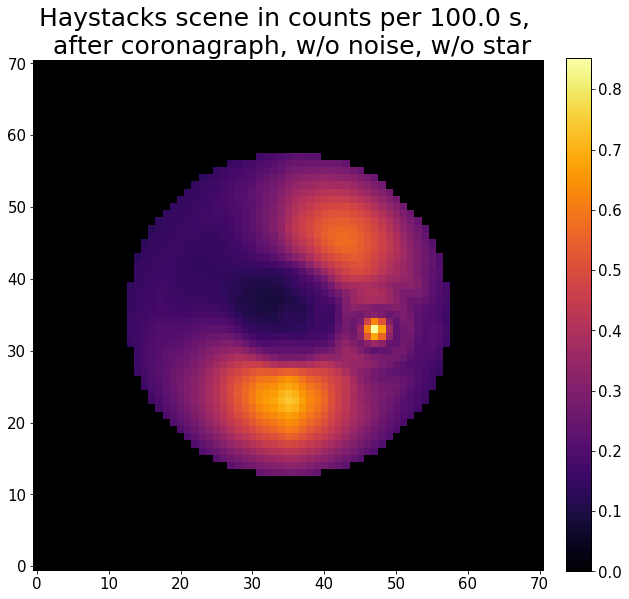

In [15]:
from crispy.tools.cgi import xy_to_psf
offax_psf_fname = 'hlc_offax_psf_quad.fits'
psf_offax = fits.getdata(offax_psf_fname)
test_scene = np.zeros((scene_imw, scene_imw)) * u.count
# this selects a frame within the cube
exptime = 100*u.s
# pseudo-convolution
for x in range(scene_imw):
    for y in range(scene_imw):
        if x != cx and y != cx:
            test_scene += hay_cube_bandavg_ph[y, x] * np.nan_to_num(xy_to_psf(x, y, psf_offax)) * exptime
plt.figure(figsize=(10,10))
plt.imshow(test_scene.value,cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Haystacks scene in counts per %s, \n after coronagraph, w/o noise, w/o star' % exptime,fontsize=25)

## With stellar PSF

Text(0.5,1,u'Haystacks scene in counts per 100.0 s, \n after coronagraph, w/o noise, w star')

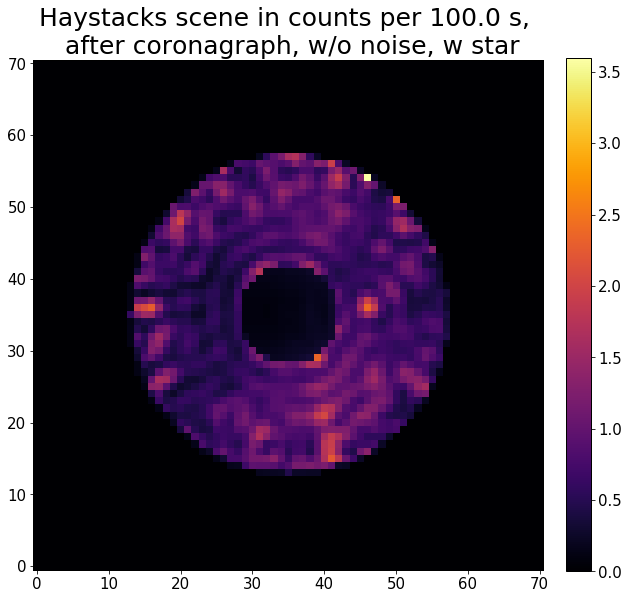

In [220]:
test_scene += rescaled_data[56]/120.*u.count/u.s*exptime
plt.figure(figsize=(10,10))
plt.imshow(test_scene.value,cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Haystacks scene in counts per %s, \n after coronagraph, w/o noise, w star' % exptime,fontsize=25)

# Full Haystacks propagation

## Propagate

In [35]:
from crispy.tools.detector import readoutPhotonFluxMapWFIRST as readoutWFIRST
exptime = 120.
inttime_target = 60.
inttime_ref = 10.

haystacks_fname = os.path.join(haystacks_path,'OS6n.fits.gz')
OS6n = fits.open(haystacks_fname)[0].data
# now the rotated map
haystacks_fname = os.path.join(haystacks_path,'OS6r.fits.gz')
OS6r = fits.open(haystacks_fname)[0].data

rescaled_data = fits.getdata(onaxis_psf_name)
psf_offax = fits.getdata(offax_psf_fname)

haystacks_img_n = np.zeros_like(rescaled_data[0])
haystacks_img_r = np.zeros_like(rescaled_data[0])
for x in range(scene_imw):
    for y in range(scene_imw):
        if x != cx and y != cx:
            psf = np.nan_to_num(xy_to_psf(x, y, psf_offax))
            haystacks_img_n += OS6n[y, x] * psf
            haystacks_img_r += OS6r[y, x] * psf


for j in range(1,len(rescaled_data)):
    if j%100==0: print(j)
    img = rescaled_data[j]/exptime
    hdr = fits.PrimaryHDU().header
    hdr.append(('EXPTIME',exptime,'Total time on target for this file'),end=True)
    hdr.append(('STARTYPE',startype[j],'1 is reference, 2 is target'),end=True)
    hdr.append(('ROLL',roll[j],'1 or 3 is one roll, 2 or 4 is other roll'),end=True)

    if startype[j]==1: inttime = inttime_ref
    elif roll[j]==1 or roll[j]==3: 
        inttime = inttime_target
        img += haystacks_img_n
    else: 
        inttime = inttime_target
        img += haystacks_img_r
    hdr.append(('INTTIME',inttime,'Time per slice on target for this file'),end=True)
        
    img = np.pad(img,pad_width=((75,75),(75,75)),mode='constant')
    
    EMGain = 4000.
    crrate = 5.0
    lifefraction = 0.5
    hprate = 3.0
    QE = 0.9
    RN = 100.
    CIC = 1e-2
    PCbias = 1000.
    pixscale = 0.4
    obs = readoutWFIRST(img,
                        tottime=exptime,
                        inttime=inttime,
                        PCcorrect=False, # don't correct for photon counting bias
                        PCmode = False,
                        EMGain= EMGain,
                        crrate = crrate,
                        hprate=hprate,
                        lifefraction=lifefraction,
                        xs=300,ys=300,
                        QE = QE,
                        RN=RN,
                        CIC=CIC,
                        PCbias=PCbias
                        ).astype(np.int)
    hdr.append(('EMGAIN',EMGain,'EM Gain'),end=True)
    hdr.append(('QE',QE,'Base QE (before lifetime degradation)'),end=True)
    hdr.append(('LIFEFRAC',lifefraction,'Fraction of 5 year lifetime'),end=True)
    hdr.append(('CRRATE',crrate,'Cosmic ray rate per second per cm2'),end=True)
    hdr.append(('HPRATE',hprate,'Hot pixel rate'),end=True)
    hdr.append(('READN',RN,'Read noise (ct/pixel)'),end=True)
    hdr.append(('CIC',CIC,'Clock-induced charge (ct/pixel)'),end=True)
    hdr.append(('PCBIAS',PCbias,'Readout bias (already removed)'),end=True)
    hdr.append(('PIXSCALE',0.4,'Pixel scale in lam/D'),end=True)
    hdr.append(('PLTSCALE',20.1,'Millarcsec/pixel'),end=True)

    fits.writeto('/Users/mrizzo/IFS/OS6/Results/os6_%d.fits' % j, obs, header=hdr, overwrite=True)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600


## Full Haystacks processing

In [241]:
hlc_psf_path = '/Users/mrizzo/IFS/OS6/'
timesteps_fname = os.path.join(hlc_psf_path, 'hlc_os6/timesteps.txt')
timesteps = np.loadtxt(timesteps_fname,skiprows=1)

print timesteps.shape
startype = timesteps[:,0]
timestep = timesteps[:,1]
exptime = timesteps[:,2]
roll = timesteps[:,3]
flux = timesteps[:,4]

Ndat_in_chunk = 55 # number of frames in a single chunk
datsize = timesteps.shape[0]
reference_chunks_ind = []
roll_plus_chunks_ind = []
roll_minus_chunks_ind = []
print datsize/Ndat_in_chunk

# cut into chunks
chunks_ind = np.split(np.arange(datsize),datsize/Ndat_in_chunk)

# assign chunks
for j in range(len(chunks_ind)):
    i = chunks_ind[j][0]
    if startype[i]==1: reference_chunks_ind.append(chunks_ind[j])
    elif roll[i]==1 or roll[i]==3: roll_minus_chunks_ind.append(chunks_ind[j])
    else: roll_plus_chunks_ind.append(chunks_ind[j])


print 'Summary:'
print 'There are %d reference chunks' % len(reference_chunks_ind)
print 'There are %d target chunks with minus 13deg roll' % len(roll_minus_chunks_ind)
print 'There are %d target chunks with plus 13deg roll' % len(roll_plus_chunks_ind)


from crispy.tools.detector import readoutPhotonFluxMapWFIRST as readoutWFIRST
reference_data_average = []
for j in range(len(reference_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(reference_chunks_ind[j])):
        ind = reference_chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/Results/os6_%d.fits' % ind
        hdu = fits.open(fname)
        obs = hdu[0].data
        hdu.close()
        chunk_indiv_frame.append(obs)
    arr = np.array(chunk_indiv_frame)-np.mean(dark_ref,axis=0)[np.newaxis,np.newaxis,:,:]
    reference_data_average.append(np.nansum(np.nansum(arr,axis=0),axis=0)/np.prod(arr.shape[:2]))

roll_minus_data_average = []
for j in range(len(roll_minus_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(roll_minus_chunks_ind[j])):
        ind = roll_minus_chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/Results/os6_%d.fits' % ind
        hdu = fits.open(fname)
        obs = hdu[0].data
        hdu.close()
        chunk_indiv_frame.append(obs)
    arr = np.array(chunk_indiv_frame)-np.mean(dark_target,axis=0)[np.newaxis,np.newaxis,:,:]
    roll_minus_data_average.append(np.nansum(np.nansum(arr,axis=0),axis=0)/np.prod(arr.shape[:2]))

roll_plus_data_average = []
for j in range(len(roll_plus_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(roll_plus_chunks_ind[j])):
        ind = roll_plus_chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/Results/os6_%d.fits' % ind
        hdu = fits.open(fname)
        obs = hdu[0].data
        hdu.close()
        chunk_indiv_frame.append(obs)
    arr = np.array(chunk_indiv_frame)-np.mean(dark_target,axis=0)[np.newaxis,np.newaxis,:,:]
    roll_plus_data_average.append(np.nansum(np.nansum(arr,axis=0),axis=0)/np.prod(arr.shape[:2]))


fits.writeto('/Users/mrizzo/IFS/OS6/references_haystacks.fits',np.array(reference_data_average), overwrite=True)
fits.writeto('/Users/mrizzo/IFS/OS6/roll_minus_haystacks.fits',np.array(roll_minus_data_average), overwrite=True)
fits.writeto('/Users/mrizzo/IFS/OS6/roll_plus_haystacks.fits',np.array(roll_plus_data_average), overwrite=True)


crop = 75
ref_series = np.array(reference_data_average)[:,crop:-crop,crop:-crop]
target_roll_minus_series = np.array(roll_minus_data_average)[:,crop:-crop,crop:-crop]
target_roll_plus_series = np.array(roll_plus_data_average)[:,crop:-crop,crop:-crop]
print ref_series.shape

ref_vec_series, data_ind, nan_ind, Np, Nexc = vectorize_image_series(ref_series, data_mask)
target_vec_minus_series, data_ind, nan_ind, Np, Nexc = vectorize_image_series(target_roll_minus_series, data_mask)
target_vec_plus_series, data_ind, nan_ind, Np, Nexc = vectorize_image_series(target_roll_plus_series, data_mask)

Nref = ref_series.shape[0]
# all_vec_series = np.concatenate([ref_vec_series, target_vec_minus_series, target_vec_plus_series], axis=0)
all_vec_series = np.concatenate([ref_vec_series, target_vec_minus_series], axis=0)

target_series = target_roll_minus_series
target_vec_series = target_vec_minus_series

raw_corr_matx = get_correlation_matrix(all_vec_series)

peak_corr = np.max( raw_corr_matx[Nref:, :Nref], axis=1 )
peak_corr_ref_ind = np.argmax( raw_corr_matx[Nref:, :Nref], axis=1 )
corr_sort_ind = np.argsort(peak_corr)[::-1]
predic_gain = 1./np.sqrt(1/peak_corr**2 - 1)

plt.figure(figsize=(10,10))
plt.title('Data correlation')
plt.imshow(raw_corr_matx,cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)


Ntarget = target_series.shape[0]

classicsub_s_cube = np.zeros((Ntarget, scene_imw, scene_imw))
refLSQ_s_cube = np.zeros((Ntarget, scene_imw, scene_imw))
klipsub_s_cube = np.zeros((Ntarget, scene_imw, scene_imw))

classicsub_s_vec = np.zeros((Ntarget, Np))
refLSQ_s_vec = np.zeros((Ntarget, Np))

Ktest = 5

for ii in range(Ntarget):
    b, a, _, _, _ = scipy.stats.linregress(ref_vec_series[ peak_corr_ref_ind[ii] ], target_vec_series[ii])
    classic_est_vec = a + b*ref_vec_series[ peak_corr_ref_ind[ii] ]
    classicsub_s_vec[ii] = target_vec_series[ii] - classic_est_vec
        
    R = ref_vec_series.copy()
    T = np.reshape(target_vec_series[ii],(1, -1))
    R_smean = np.tile(np.reshape(np.mean(R, axis=1),(R.shape[0],1)), (1, R.shape[1]))
    Rs = R - R_smean
    T_smean = np.tile(np.mean(T, axis=1), (1, T.shape[1]))
    Ts = T - T_smean
    Xhat_refLSQ = Ts.dot(np.linalg.pinv(Rs)).dot(Rs)
    refLSQ_s_vec[ii] = Ts - Xhat_refLSQ
    
    # get klip-subtracted vectors over the range of K values
    target_s_vec = target_vec_series[ii].reshape((1,-1))
    klipsub_s_vec = rdi_klipsub(ref_vec_series, target_s_vec, Ktest)
    
    # reconstruct KLIP residual
    klipsub_s_cube[ii] = reconstruct_image_series(klipsub_s_vec, data_ind, nan_ind, scene_imw, scene_imw)
    
classicsub_s_cube = reconstruct_image_series(classicsub_s_vec, data_ind, nan_ind, scene_imw, scene_imw)
refLSQ_s_cube = reconstruct_image_series(refLSQ_s_vec, data_ind, nan_ind, scene_imw, scene_imw)


## Single slice

##############################
RMS in the dark hole residuals
##############################
Classical:  603.661108722
Least Squares:  598.302910487
KLIP:  599.856402899


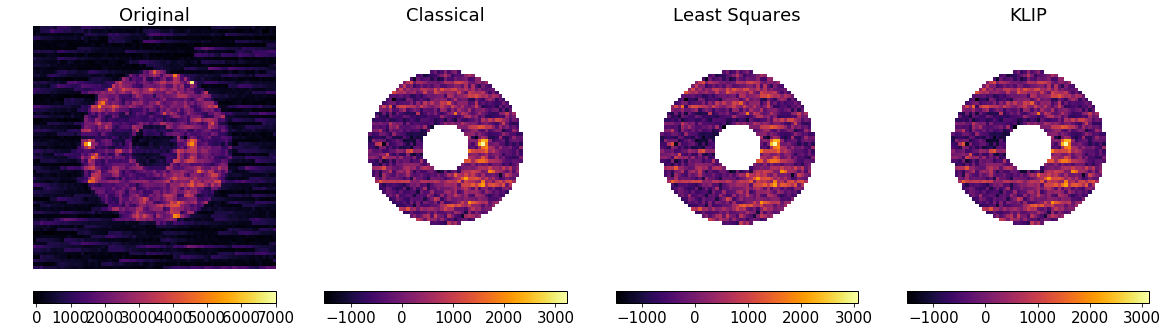

In [242]:
slice_select = -1

plt.figure(figsize=(20,10))
plt.subplot(141)
plt.title('Original')
plt.imshow(target_series[slice_select],cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.axis('off')
plt.subplot(142)
plt.title('Classical')
plt.imshow(classicsub_s_cube[slice_select],cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.axis('off')
plt.subplot(143)
plt.title('Least Squares')
plt.imshow(refLSQ_s_cube[slice_select],cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.axis('off')
plt.subplot(144)
plt.title('KLIP')
plt.imshow(klipsub_s_cube[slice_select],cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.axis('off')

print '##############################'
print 'RMS in the dark hole residuals'
print '##############################'
print 'Classical: ',np.nanstd(classicsub_s_cube[slice_select])
print 'Least Squares: ',np.nanstd(refLSQ_s_cube[slice_select])
print 'KLIP: ',np.nanstd(klipsub_s_cube[slice_select])

## Average

/Users/mrizzo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/Users/mrizzo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/Users/mrizzo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


(-0.5, 70.5, -0.5, 70.5)

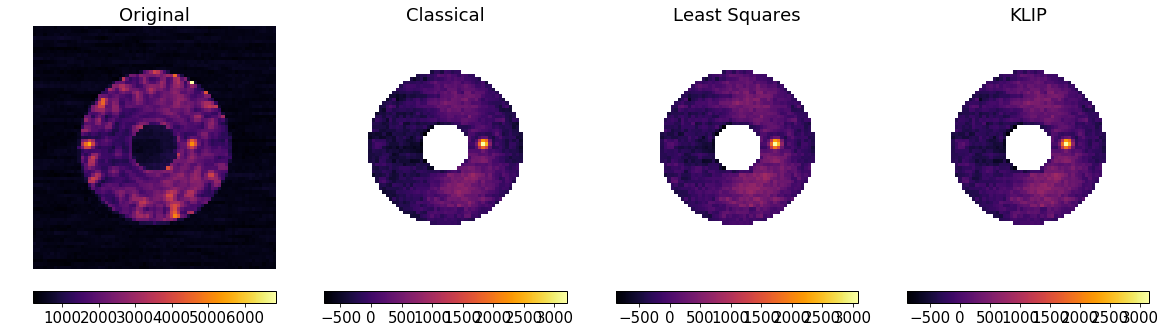

In [246]:
plt.figure(figsize=(20,10))
plt.subplot(141)
plt.title('Original')
plt.imshow(np.nanmean(target_series,axis=0),cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.axis('off')
plt.subplot(142)
plt.title('Classical')
plt.imshow(np.nanmean(classicsub_s_cube,axis=0),cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.axis('off')
plt.subplot(143)
plt.title('Least Squares')
plt.imshow(np.nanmean(refLSQ_s_cube,axis=0),cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.axis('off')
plt.subplot(144)
plt.title('KLIP')
plt.imshow(np.nanmean(klipsub_s_cube,axis=0),cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.axis('off')


## Cosmic ray masking attempt

### Scratch - flattening the arrays correctly

In [268]:
roll_minus_data_average = []
for j in range(len(roll_minus_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(roll_minus_chunks_ind[j])):
        ind = roll_minus_chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/Results/os6_%d.fits' % ind
        hdu = fits.open(fname)
        obs = hdu[0].data
        hdu.close()
        chunk_indiv_frame.append(obs)
    arr = np.array(chunk_indiv_frame)
    arr = np.reshape(arr,(np.prod(arr.shape[:2]),arr.shape[2],arr.shape[3])).astype(np.float)
    mask = np.zeros_like(arr,dtype=np.bool)
    for nslice in range(len(arr)):
        for ix in range(75,arr.shape[-1]-75):
            for iy in range(arr.shape[-1]):
                if arr[nslice,ix,iy]>65000:
                    arr[nslice,ix,:] = np.NaN
                    continue
#     arr[mask] = np.NaN
    roll_minus_data_average.append(np.nanmean(arr,axis=0))


(55, 12, 221, 221)
(660, 221, 221)


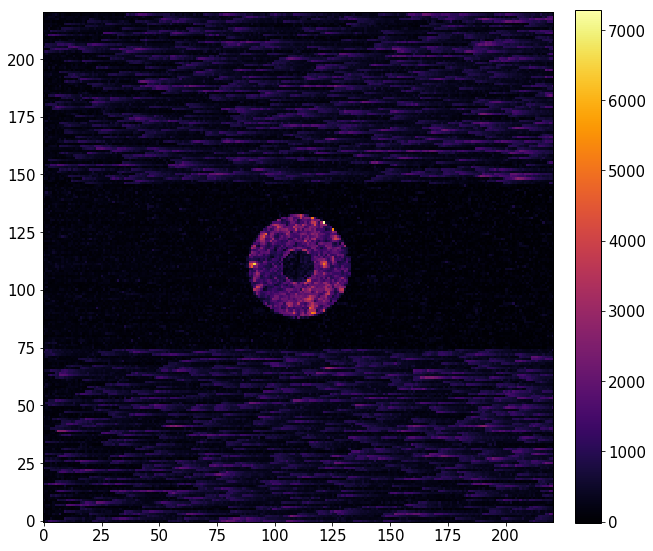

In [270]:
plt.figure(figsize=(10,10))
plt.imshow(roll_minus_data_average[0],cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)


### Scratch - find saturated pixels and eliminate rows

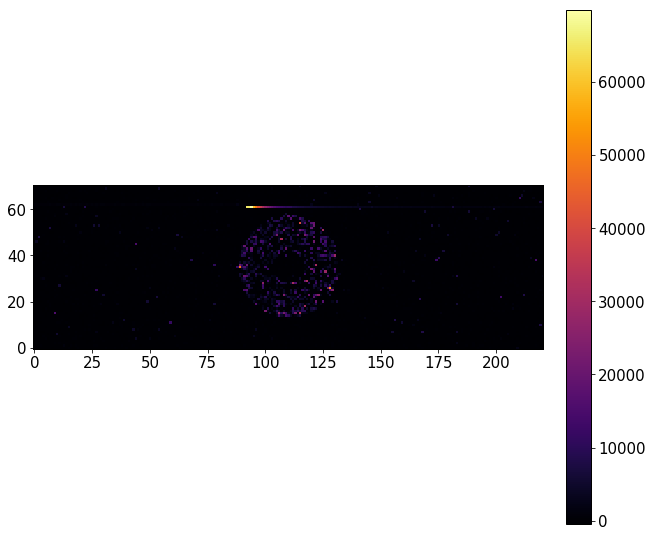

In [255]:
plt.figure(figsize=(10,10))
plt.imshow(test[0,75:-75,:],cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)


In [256]:
for nslice in range(len(test)):
    for ix in range(75,test.shape[-1]-75):
        for iy in range(test.shape[-1]):
            if test[nslice,ix,iy]>65000:
                test[nslice,ix,:] = np.NaN
                continue

In [258]:
fits.writeto('/Users/mrizzo/Downloads/scratch.fits',test,overwrite=True)

### Apply

In [36]:
hlc_psf_path = '/Users/mrizzo/IFS/OS6/'
timesteps_fname = os.path.join(hlc_psf_path, 'hlc_os6/os6_timesteps.txt')
timesteps = np.loadtxt(timesteps_fname,skiprows=1)

print timesteps.shape
startype = timesteps[:,0]
timestep = timesteps[:,1]
exptime = timesteps[:,2]
roll = timesteps[:,3]
flux = timesteps[:,4]

Ndat_in_chunk = 55 # number of frames in a single chunk
datsize = timesteps.shape[0]
reference_chunks_ind = []
roll_plus_chunks_ind = []
roll_minus_chunks_ind = []
print datsize/Ndat_in_chunk

# cut into chunks
chunks_ind = np.split(np.arange(datsize),datsize/Ndat_in_chunk)

# assign chunks
for j in range(len(chunks_ind)):
    i = chunks_ind[j][0]
    if startype[i]==1: reference_chunks_ind.append(chunks_ind[j])
    elif roll[i]==1 or roll[i]==3: roll_minus_chunks_ind.append(chunks_ind[j])
    else: roll_plus_chunks_ind.append(chunks_ind[j])


print 'Summary:'
print 'There are %d reference chunks' % len(reference_chunks_ind)
print 'There are %d target chunks with minus 13deg roll' % len(roll_minus_chunks_ind)
print 'There are %d target chunks with plus 13deg roll' % len(roll_plus_chunks_ind)


from crispy.tools.detector import readoutPhotonFluxMapWFIRST as readoutWFIRST
reference_data_average = []
for j in range(len(reference_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(reference_chunks_ind[j])):
        ind = reference_chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/Results/os6_%d.fits' % ind
        hdu = fits.open(fname)
        obs = hdu[0].data
        hdu.close()
        chunk_indiv_frame.append(obs)
    arr = np.array(chunk_indiv_frame)
    arr = np.reshape(arr,(np.prod(arr.shape[:2]),arr.shape[2],arr.shape[3])).astype(np.float)
    for nslice in range(len(arr)):
        for ix in range(75,arr.shape[-1]-75):
            for iy in range(arr.shape[-1]):
                if arr[nslice,ix,iy]>65000:
                    arr[nslice,ix,:] = np.NaN
                    continue
    reference_data_average.append(np.nanmean(arr,axis=0))

roll_minus_data_average = []
for j in range(len(roll_minus_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(roll_minus_chunks_ind[j])):
        ind = roll_minus_chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/Results/os6_%d.fits' % ind
        hdu = fits.open(fname)
        obs = hdu[0].data
        hdu.close()
        chunk_indiv_frame.append(obs)
    arr = np.array(chunk_indiv_frame)
    arr = np.reshape(arr,(np.prod(arr.shape[:2]),arr.shape[2],arr.shape[3])).astype(np.float)
    for nslice in range(len(arr)):
        for ix in range(75,arr.shape[-1]-75):
            for iy in range(arr.shape[-1]):
                if arr[nslice,ix,iy]>65000:
                    arr[nslice,ix,:] = np.NaN
                    continue
    roll_minus_data_average.append(np.nanmean(arr,axis=0))

roll_plus_data_average = []
for j in range(len(roll_plus_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(roll_plus_chunks_ind[j])):
        ind = roll_plus_chunks_ind[j][i]
        fname = '/Users/mrizzo/IFS/OS6/Results/os6_%d.fits' % ind
        hdu = fits.open(fname)
        obs = hdu[0].data
        hdu.close()
        chunk_indiv_frame.append(obs)
    arr = np.array(chunk_indiv_frame)
    arr = np.reshape(arr,(np.prod(arr.shape[:2]),arr.shape[2],arr.shape[3])).astype(np.float)
    for nslice in range(len(arr)):
        for ix in range(75,arr.shape[-1]-75):
            for iy in range(arr.shape[-1]):
                if arr[nslice,ix,iy]>65000:
                    arr[nslice,ix,:] = np.NaN
                    continue
    roll_plus_data_average.append(np.nanmean(arr,axis=0))


fits.writeto('/Users/mrizzo/IFS/OS6/references_haystacks.fits',np.array(reference_data_average), overwrite=True)
fits.writeto('/Users/mrizzo/IFS/OS6/roll_minus_haystacks.fits',np.array(roll_minus_data_average), overwrite=True)
fits.writeto('/Users/mrizzo/IFS/OS6/roll_plus_haystacks.fits',np.array(roll_plus_data_average), overwrite=True)

(3630, 5)
66
Summary:
There are 14 reference chunks
There are 26 target chunks with minus 13deg roll
There are 26 target chunks with plus 13deg roll


### Post-process

(14, 71, 71)


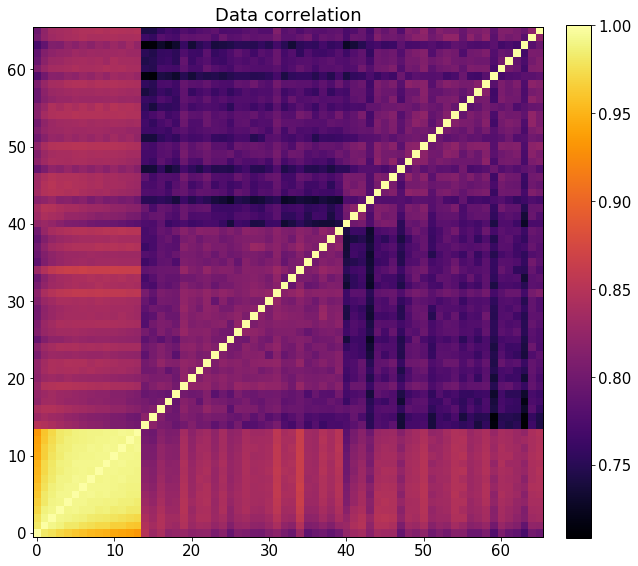

In [196]:
crop = 75
ref_series = np.array(reference_data_average)[:,crop:-crop,crop:-crop]
target_roll_minus_series = np.array(roll_minus_data_average)[:,crop:-crop,crop:-crop]
target_roll_plus_series = np.array(roll_plus_data_average)[:,crop:-crop,crop:-crop]
# target_roll_plus_series = np.zeros_like(target_roll_plus_series_old)
print ref_series.shape

# for i in range(len(target_roll_plus_series)):
#     target_roll_plus_series[i] = skimage.transform.rotate(target_roll_plus_series_old[i], angle = -26,
#                        order = 3, resize = False,
#                        center=(cx, cx), cval=np.nan)


ref_vec_series, data_ind, nan_ind, Np, Nexc = vectorize_image_series(ref_series, data_mask)
target_vec_minus_series, data_ind, nan_ind, Np, Nexc = vectorize_image_series(target_roll_minus_series, data_mask)
target_vec_plus_series, data_ind, nan_ind, Np, Nexc = vectorize_image_series(target_roll_plus_series, data_mask)

Nref = ref_series.shape[0]
all_vec_series = np.concatenate([ref_vec_series, target_vec_minus_series, target_vec_plus_series], axis=0)
# all_vec_series = np.concatenate([ref_vec_series, target_vec_minus_series], axis=0)

target_series = np.concatenate([target_roll_minus_series, target_roll_plus_series], axis=0)
target_vec_series = np.concatenate([target_vec_minus_series, target_vec_plus_series], axis=0)

raw_corr_matx = get_correlation_matrix(all_vec_series)

peak_corr = np.max( raw_corr_matx[Nref:, :Nref], axis=1 )
peak_corr_ref_ind = np.argmax( raw_corr_matx[Nref:, :Nref], axis=1 )
corr_sort_ind = np.argsort(peak_corr)[::-1]
predic_gain = 1./np.sqrt(1/peak_corr**2 - 1)

plt.figure(figsize=(10,10))
plt.title('Data correlation')
plt.imshow(raw_corr_matx,cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)


Ntarget = target_series.shape[0]

classicsub_s_cube = np.zeros((Ntarget, scene_imw, scene_imw))
refLSQ_s_cube = np.zeros((Ntarget, scene_imw, scene_imw))
klipsub_s_cube = np.zeros((Ntarget, scene_imw, scene_imw))

classicsub_s_vec = np.zeros((Ntarget, Np))
refLSQ_s_vec = np.zeros((Ntarget, Np))

Ktest = 5

for ii in range(Ntarget):
    b, a, _, _, _ = scipy.stats.linregress(ref_vec_series[ peak_corr_ref_ind[ii] ], target_vec_series[ii])
    classic_est_vec = a + b*ref_vec_series[ peak_corr_ref_ind[ii] ]
    classicsub_s_vec[ii] = target_vec_series[ii] - classic_est_vec
        
    R = ref_vec_series.copy()
    T = np.reshape(target_vec_series[ii],(1, -1))
    R_smean = np.tile(np.reshape(np.mean(R, axis=1),(R.shape[0],1)), (1, R.shape[1]))
    Rs = R - R_smean
    T_smean = np.tile(np.mean(T, axis=1), (1, T.shape[1]))
    Ts = T - T_smean
    Xhat_refLSQ = Ts.dot(np.linalg.pinv(Rs)).dot(Rs)
    refLSQ_s_vec[ii] = Ts - Xhat_refLSQ
    
    # get klip-subtracted vectors over the range of K values
    target_s_vec = target_vec_series[ii].reshape((1,-1))
    klipsub_s_vec = rdi_klipsub(ref_vec_series, target_s_vec, Ktest)
    
    # reconstruct KLIP residual
    klipsub_s_cube[ii] = reconstruct_image_series(klipsub_s_vec, data_ind, nan_ind, scene_imw, scene_imw)
    
classicsub_s_cube = reconstruct_image_series(classicsub_s_vec, data_ind, nan_ind, scene_imw, scene_imw)
refLSQ_s_cube = reconstruct_image_series(refLSQ_s_vec, data_ind, nan_ind, scene_imw, scene_imw)

## Plot first roll

/Users/mrizzo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/Users/mrizzo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/Users/mrizzo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


(-0.5, 70.5, -0.5, 70.5)

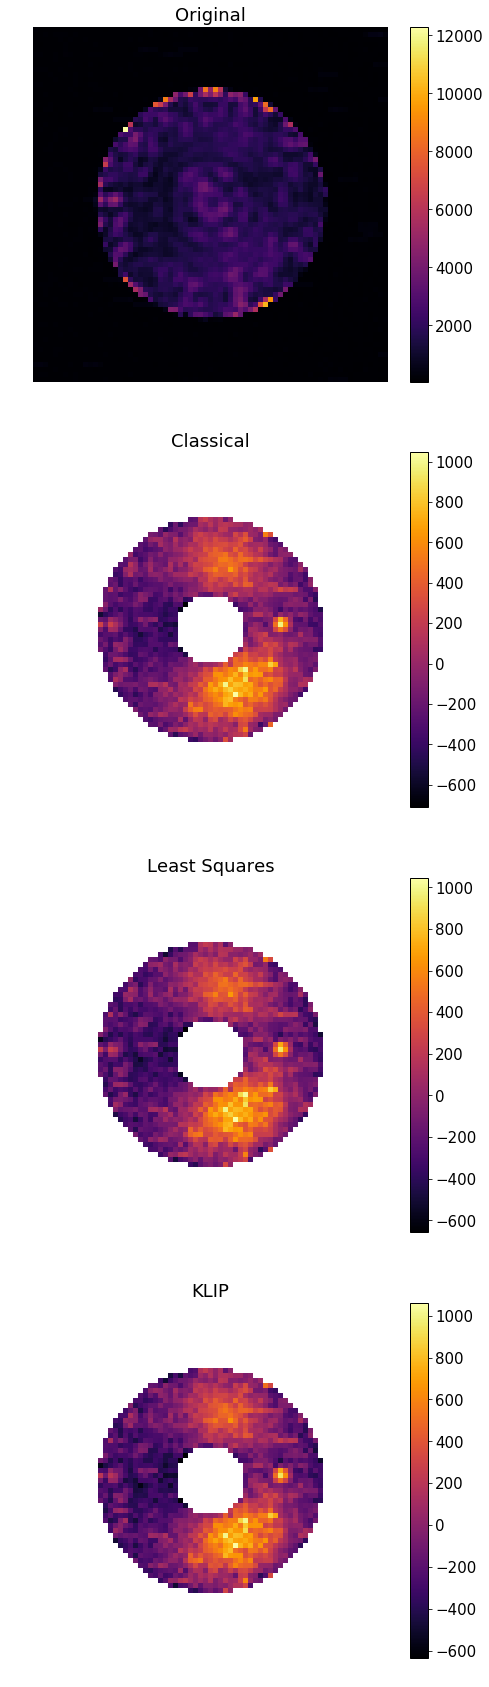

In [38]:
plt.figure(figsize=(10,30))
plt.subplot(411)
plt.title('Original')
plt.imshow(np.nanmean(target_series[:Ntarget//2],axis=0),cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.subplot(412)
plt.title('Classical')
plt.imshow(np.nanmean(classicsub_s_cube[:Ntarget//2],axis=0),cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.subplot(413)
plt.title('Least Squares')
plt.imshow(np.nanmean(refLSQ_s_cube[:Ntarget//2],axis=0),cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.subplot(414)
plt.title('KLIP')
plt.imshow(np.nanmean(klipsub_s_cube[:Ntarget//2],axis=0),cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')


## Plot second roll

/Users/mrizzo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/Users/mrizzo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/Users/mrizzo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


(-0.5, 70.5, -0.5, 70.5)

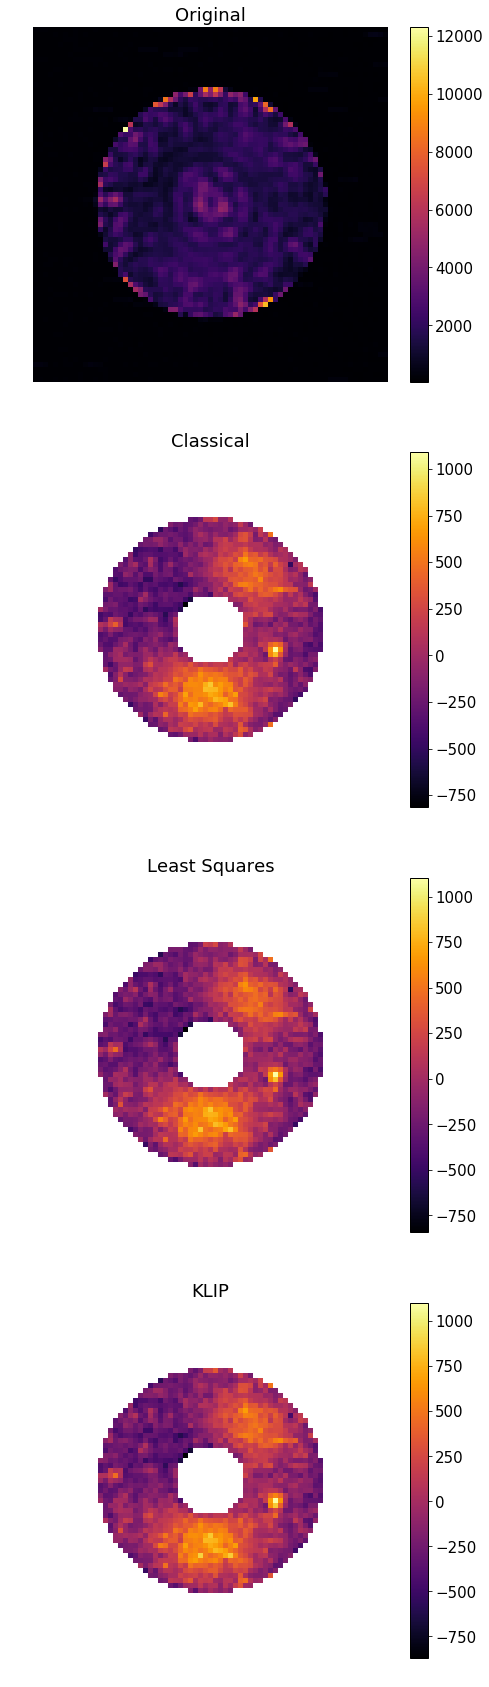

In [39]:
plt.figure(figsize=(10,30))
plt.subplot(411)
plt.title('Original')
plt.imshow(np.nanmean(target_series[Ntarget//2:],axis=0),cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.subplot(412)
plt.title('Classical')
plt.imshow(np.nanmean(classicsub_s_cube[Ntarget//2:],axis=0),cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.subplot(413)
plt.title('Least Squares')
plt.imshow(np.nanmean(refLSQ_s_cube[Ntarget//2:],axis=0),cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.subplot(414)
plt.title('KLIP')
plt.imshow(np.nanmean(klipsub_s_cube[Ntarget//2:],axis=0),cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')


# Graphics

(71, 71) (71, 71)


/Users/mrizzo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/Users/mrizzo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice


(-0.5, 70.5, -0.5, 70.5)

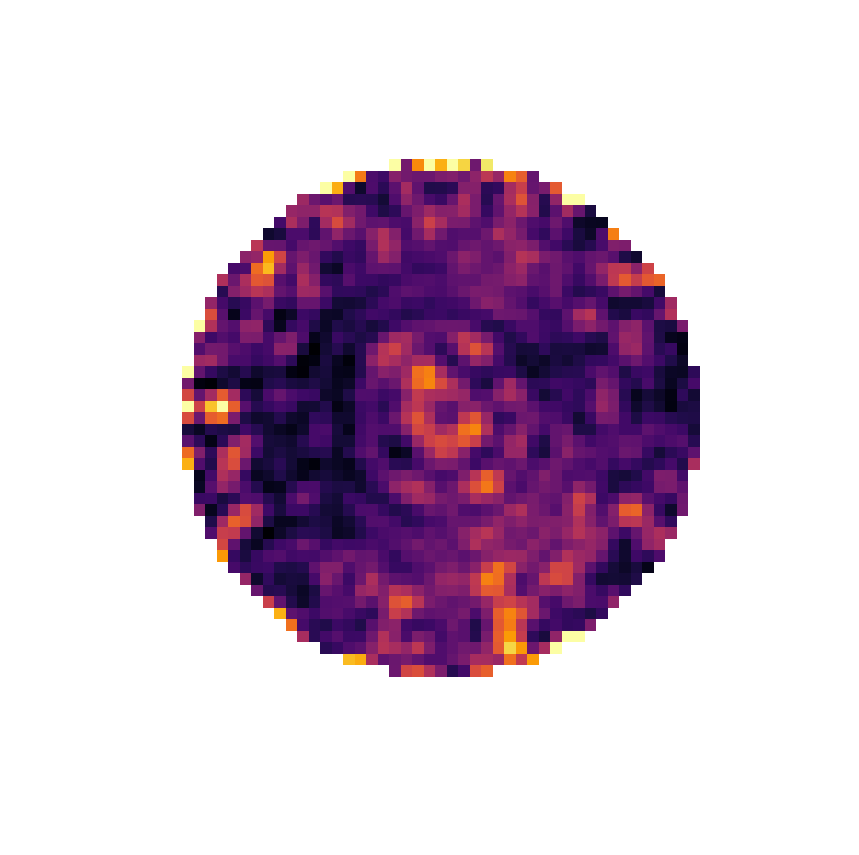

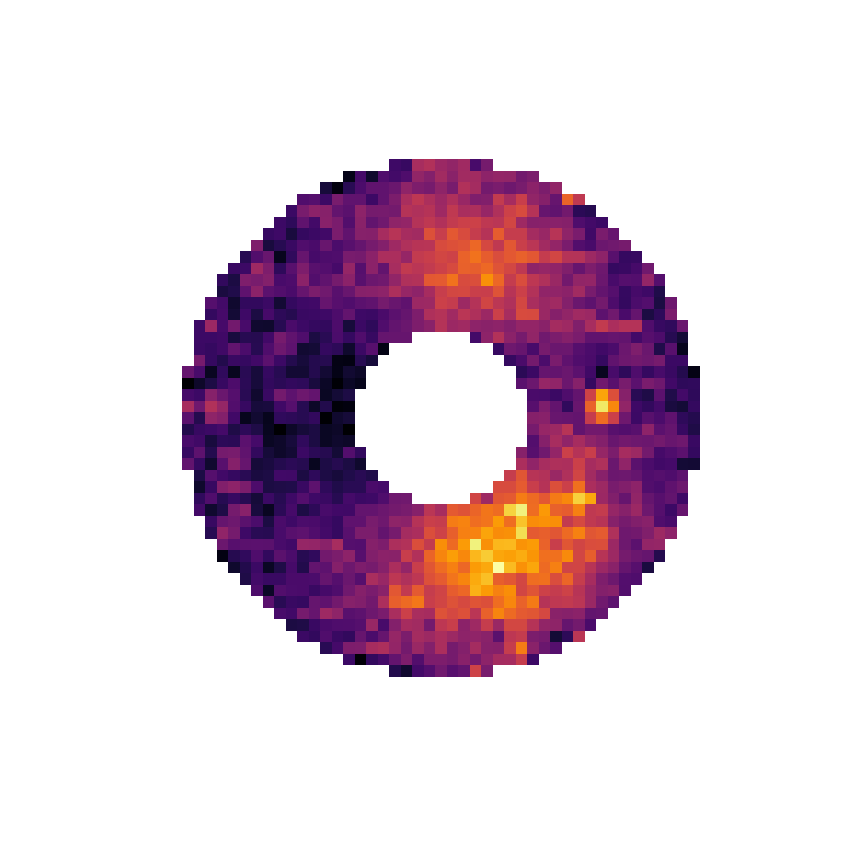

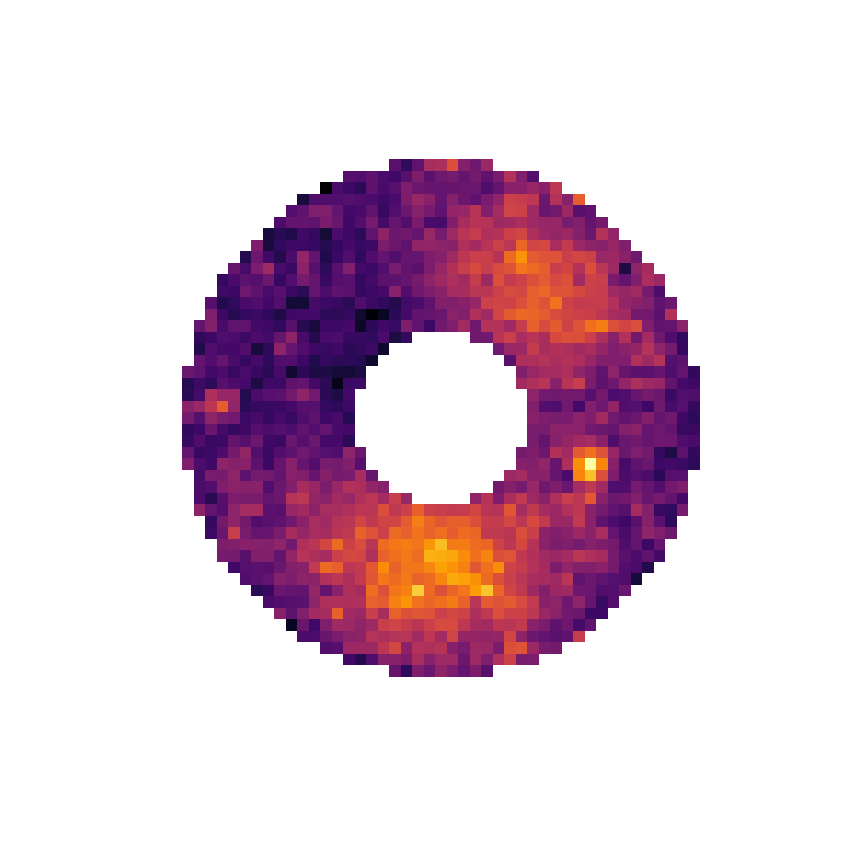

In [205]:
x_try = np.arange(scene_imw)
y_try = np.arange(scene_imw)

x_try, y_try = np.meshgrid(x_try, y_try)
xs_p = np.arange(scene_imw) - cx
ys_p = xs_p.copy()
xxs_p, yys_p = np.meshgrid(xs_p, ys_p)
rrs_p = np.sqrt(xxs_p**2 + yys_p**2)
data_select_OWA = (rrs_p >= 9. / pixscale_LoD)
data_mask_OWA = np.where(np.equal(~data_select_OWA, 1), 1, np.nan)

print target_series[0].shape,data_select_OWA.shape

plt.figure(figsize=(15,15))

mean = np.nanmean(target_series[:Ntarget//2],axis=0)
mean[data_select_OWA] = np.NaN
plt.imshow(mean,cmap=cmap,vmax=5000)
# plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')

plt.figure(figsize=(15,15))

plt.imshow(np.nanmean(klipsub_s_cube[:Ntarget//2],axis=0),cmap=cmap)
# plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.figure(figsize=(15,15))

plt.imshow(np.nanmean(klipsub_s_cube[Ntarget//2:],axis=0),cmap=cmap)
# plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')


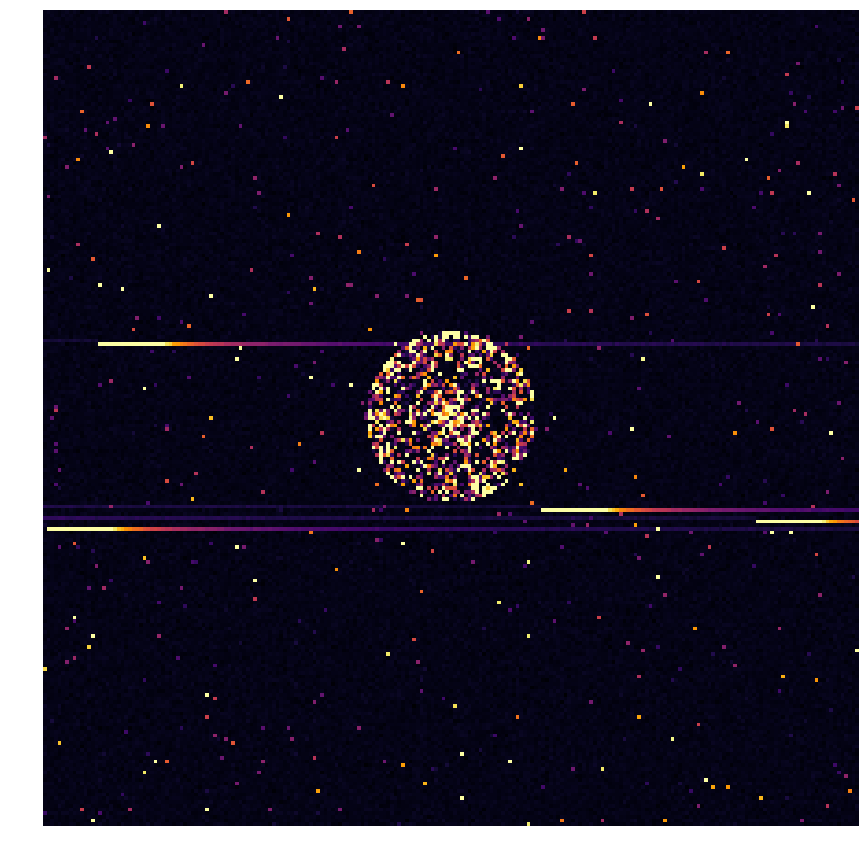

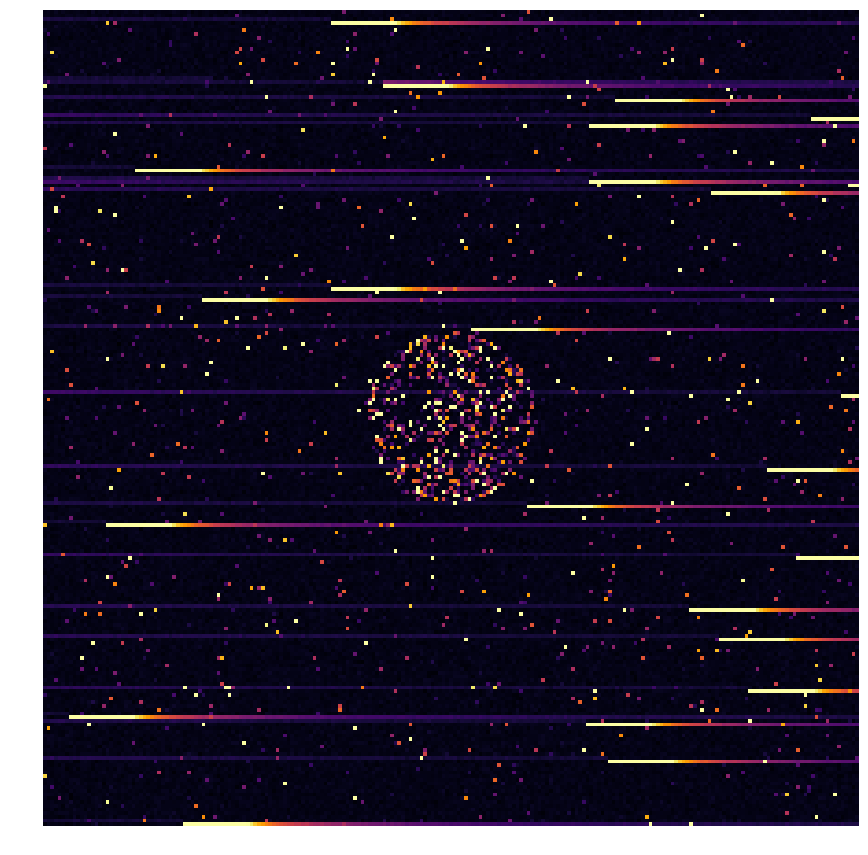

In [215]:
plt.figure(figsize=(15,15))
plt.imshow(fits.getdata('/Users/mrizzo/IFS/OS6/Results/os6_1.fits')[0],cmap=cmap,vmax=10000)
# plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.figure(figsize=(15,15))
plt.imshow(fits.getdata('/Users/mrizzo/IFS/OS6/Results/os6_56.fits')[0],cmap=cmap,vmax=10000)
# plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.savefig('/Users/mrizzo/Downloads/HLC_detector.png',dpi=300)

## Data correlation matrix

In [212]:
chunks_ind = np.split(np.arange(datsize),datsize/Ndat_in_chunk)
print "Number of chunks:",len(chunks_ind)

data_average = []
for j in range(len(chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(chunks_ind[j])):
        ind = chunks_ind[j][i]
        chunk_indiv_frame.append(rescaled_data[ind])
    data_average.append(np.nanmean(np.array(chunk_indiv_frame),axis=0))

data_average = np.array(data_average)

data_nonoise_vec, data_ind, nan_ind, N_pix, N_mask = vectorize_image_series(data_average,data_mask)

Number of chunks: 66


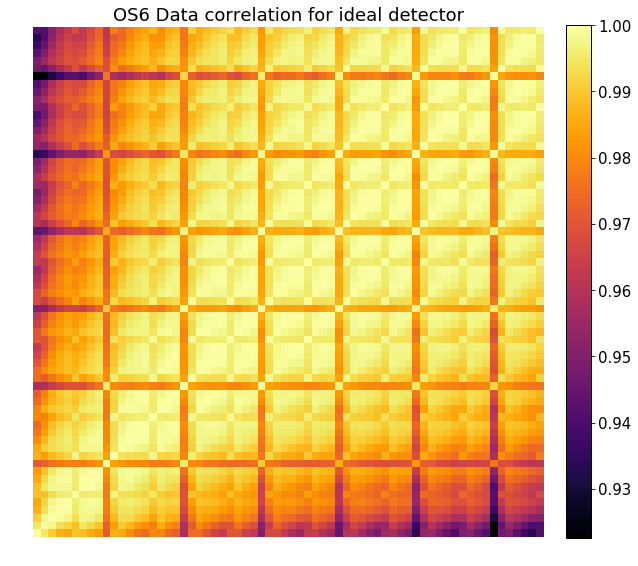

In [213]:
raw_corr_matx = get_correlation_matrix(data_nonoise_vec)
plt.figure(figsize=(10,10))
plt.title('OS6 Data correlation for ideal detector')
plt.imshow(raw_corr_matx,cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
plt.savefig('/Users/mrizzo/Downloads/Data_Corr.png',dpi=300)

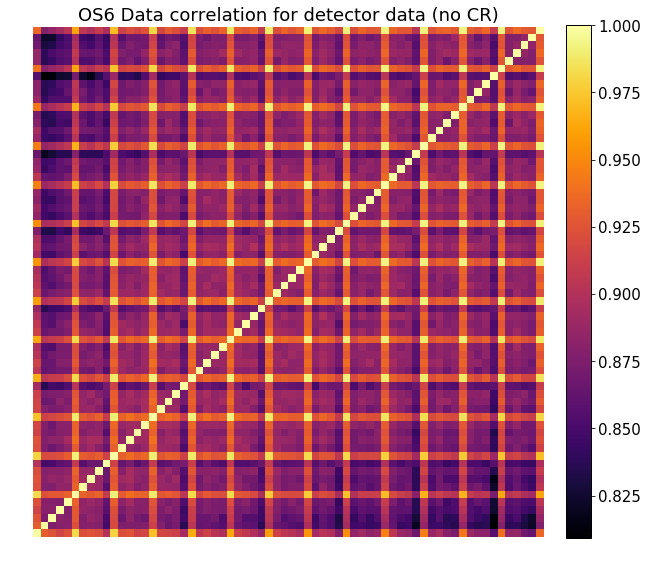

In [214]:
data_average = []
x_try = np.arange(scene_imw)
y_try = np.arange(scene_imw)

x_try, y_try = np.meshgrid(x_try, y_try)
xs_p = np.arange(scene_imw) - cx
ys_p = xs_p.copy()
xxs_p, yys_p = np.meshgrid(xs_p, ys_p)
rrs_p = np.sqrt(xxs_p**2 + yys_p**2)
data_select = np.logical_or(rrs_p >= 9. / pixscale_LoD,rrs_p <= 3. / pixscale_LoD)
data_mask = np.where(np.equal(~data_select, 1), 1, np.nan)

for j in range(len(chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(chunks_ind[j])):
        ind = chunks_ind[j][i]
        obs = readoutWFIRST(rescaled_data[ind]/120.,
                                                tottime=120.,
                                                inttime=120.,
                                                PCcorrect=False, # don't correct for photon counting bias
                                                PCmode = False,
                                                crrate = 0.0,
                                                hprate=3.0,
                                                lifefraction=0.5,
                                                xs=100,ys=100,
                                                QE = 0.9,
                                                ).astype(np.int)
        chunk_indiv_frame.append(obs)
    data_average.append(np.nanmean(np.array(chunk_indiv_frame),axis=0))
data_average = np.array(data_average)

data_nonoise_vec, data_ind, nan_ind, N_pix, N_mask = vectorize_image_series(data_average,data_mask)
raw_corr_matx = get_correlation_matrix(data_nonoise_vec)
plt.figure(figsize=(10,10))
plt.title('OS6 Data correlation for detector data (no CR)')
plt.imshow(raw_corr_matx,cmap=cmap)
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig('/Users/mrizzo/Downloads/Data_Corr_noisy.png',dpi=300)

## Study jitter

In [83]:
hlc_psf_path = '/Users/mrizzo/IFS/OS6/'
jitter_fname = os.path.join(hlc_psf_path, 'hlc_os6/os6_jitter.txt')
jitter = np.loadtxt(jitter_fname,skiprows=3)

minor = jitter[:,1]
major = jitter[:,2]
angle = jitter[:,3]

In [85]:
rms = np.sqrt(minor**2+major**2)
rms_to_chunks = np.reshape(rms,(55,66))
mean_rms = np.mean(rms_to_chunks,axis=0)

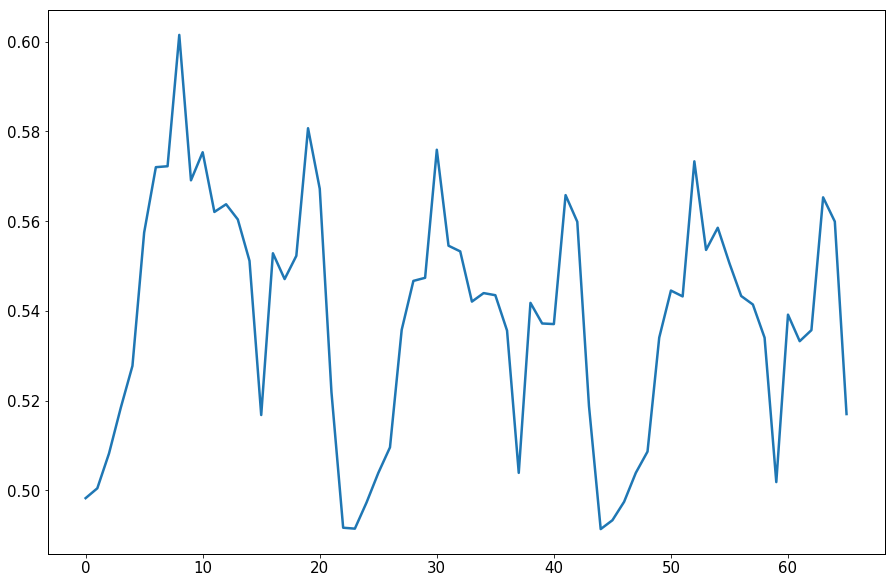

In [201]:
plt.figure(figsize=(15,10))
plt.plot(mean_rms)

# Create peak map

/Users/mrizzo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: All-NaN slice encountered


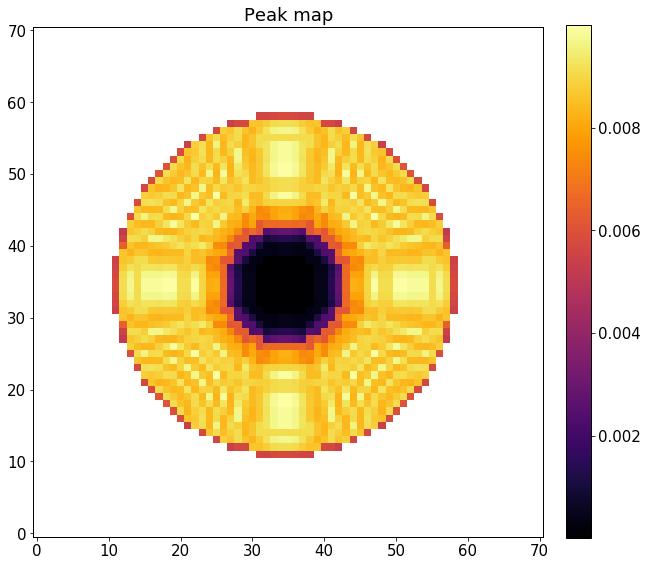

In [127]:

peak_map = np.zeros((scene_imw,scene_imw))
for x in range(scene_imw):
    for y in range(scene_imw):
            peak_map[x,y] = np.nanmax(xy_to_psf(x, y, psf_offax))
            
plt.figure(figsize=(10,10))
plt.title('Peak map')
plt.imshow(peak_map,cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)

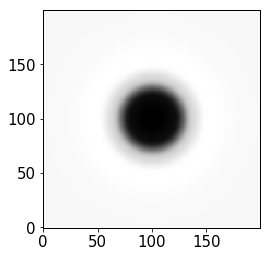

In [153]:
pm = fits.getdata(hlc_psf_path+'hlc_os6/psf_peak_map.fits')
plt.imshow(pm)
pm = np.pad(pm, ((2,2), (2,2)),mode='constant')

In [157]:
s = binfac
new_pm = skimage.transform.rescale(pm,(s, s), order=interp_order,mode='reflect') / s**2

outpm = np.zeros((scene_imw,scene_imw))
zpw = (scene_imw - new_pm.shape[-1]) // 2
outpm[zpw:-zpw, zpw:-zpw] = new_pm

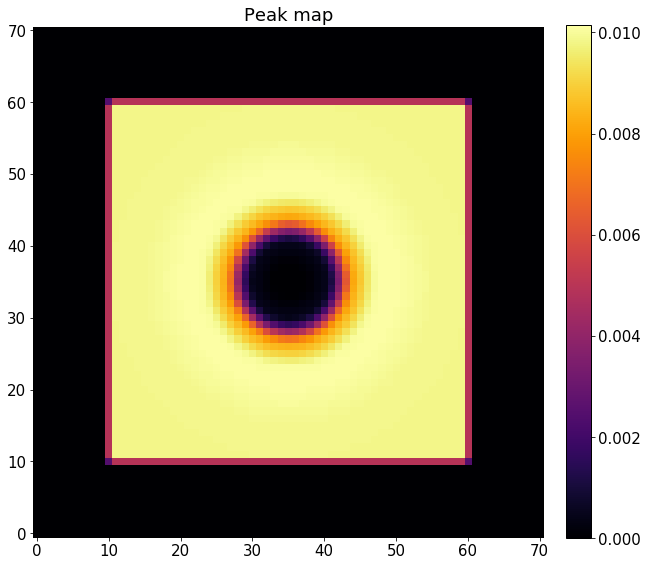

In [158]:
plt.figure(figsize=(10,10))
plt.title('Peak map')
plt.imshow(outpm,cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)

In [138]:
print new_pm.shape
peakmap = np.zeros_like(klipsub_s_cube[0])
peakmap[11:61,11:61] += new_pm

(50, 50)


# Normalize to contrast

/Users/mrizzo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


(-0.5, 70.5, -0.5, 70.5)

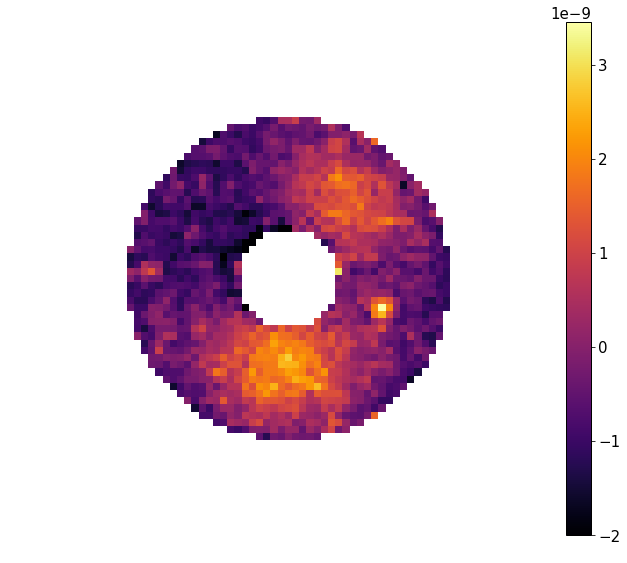

In [182]:
img = np.nanmean(classicsub_s_cube[Ntarget//2:],axis=0)
# img = np.nanmean(refLSQ_s_cube[:Ntarget//2],axis=0)
plt.figure(figsize=(10,10))
plt.imshow(img/5000./0.9/(1.15e8*60)/outpm,cmap=cmap,vmin=-2e-9)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')


/Users/mrizzo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


-1.21359916301e-15


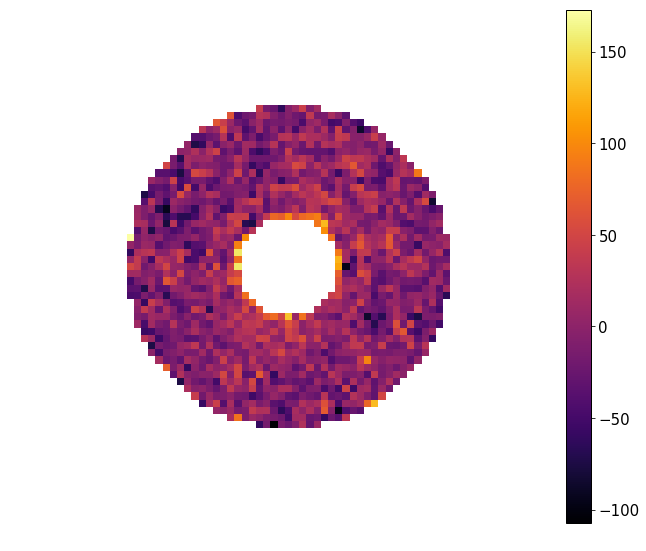

In [186]:
plt.figure(figsize=(10,10))
diff = np.nanmean(classicsub_s_cube[Ntarget//2:],axis=0) - np.nanmean(refLSQ_s_cube[Ntarget//2:],axis=0)
plt.imshow(diff,cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
print np.nanmean(diff)

# Roll subtraction

/Users/mrizzo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/Users/mrizzo/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


(-0.5, 70.5, -0.5, 70.5)

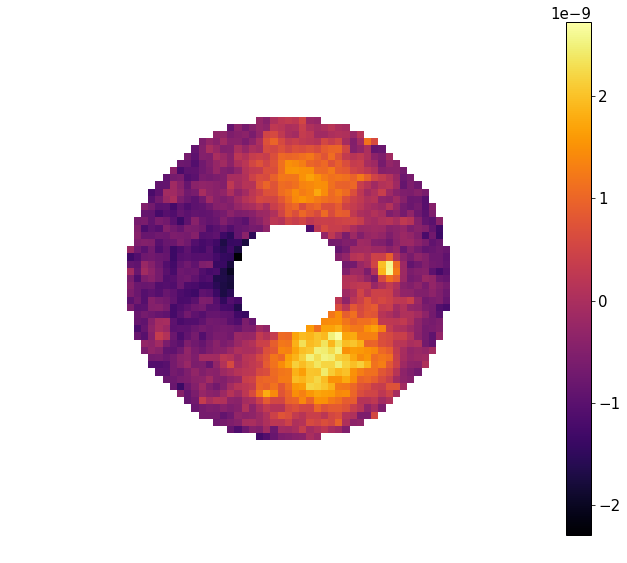

In [199]:
first_roll = np.nanmean(classicsub_s_cube[:Ntarget//2],axis=0)
second_roll = np.nanmean(classicsub_s_cube[Ntarget//2:],axis=0)
second_roll[np.isnan(second_roll)]=0.0

rotated_roll = skimage.transform.rotate(second_roll, angle = -26,
                       order = 3, resize = False,
                       center=(cx, cx), cval=np.nan)

plt.figure(figsize=(10,10))
plt.imshow(0.5*(rotated_roll+first_roll)/5000./0.9/(1.15e8*60)/outpm,cmap=cmap)
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis('off')
